# Download Datasets
We'll use the genetic variant database at [THIS](https://github.com/bowang-lab/genomic-FM) link.

For variants, we'll go with the ClinVar pathogenicity classification task (pathogenic, likely pathogenic, likely benign, benign)

# Using this notebook:

There are two different tracks for using this notebook.
- **Path A**: Train all of your own models from scratch!
- **Path B**: Run interpretability on previously trained models.

Regardless of the path you're taking, you will execute each cell in order. **HOWEVER, DO NOT execute cells which are labeled as being exlusive to a different path**. Mainly, look out for:

Path A:
- Step "5a. Training Loop"
- Step "2a. Train SAE"

Path B:
- Step "5b. Load saved model"
- Step "2b. Load SAE"

Users on Path A should execute cells 1 -> 2 -> 3 -> 4 -> 5a -> 1 -> 2a -> ...

Users on Path B Should execute cells 1 -> 2 -> 3 -> 4 -> 5b -> 1 -> 2b -> ...


In [1]:
# (optional but recommended) Mount Google Drive so data persists
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


🚨WARNING!!🚨

This cell may ask you to 'restart the runtime'. Please click the button to restart the runtime in the error logs, then run this cell again. The warning should disappear on the second run.

In [2]:
# Clone repo from GitHub, install dependencies (Takes approx 2min)
!git clone https://github.com/bowang-lab/genomic-FM.git
%cd genomic-FM/
!pip install torch torchvision
!pip -q install -r requirements.txt

Cloning into 'genomic-FM'...
remote: Enumerating objects: 1774, done.
remote: Counting objects: 100% (443/443), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 1774 (delta 355), reused 329 (delta 273), pack-reused 1331 (from 2)
Receiving objects: 100% (1774/1774), 2.74 MiB | 3.96 MiB/s, done.
Resolving deltas: 100% (1065/1065), done.
/content/genomic-FM
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 79.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.4/826.4 kB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.9/14

🚨WARNING!!🚨

Downloading the full dataset can take >20min the first time. Saving the dataset to your Google Drive prevents needing to redownload all the data each time you reload the notebook.

YOU MUST HAVE AT LEAST 11GB OF FREEE SPACE ON YOUR GOOGLE DRIVE TO SAVE THERE!
- If you do NOT have 11GB of free space, skip the following cell, and proceed to downloading the dataset. The data will NOT be downloaded onto your google drive, and you will need to redownload the dataset each time you re-run the notebook.

This cell may say 'unable to make symbolic link'. If this is the case, please re-run the cell and the symbolic link should be created.

In [3]:
# (optional but recommended) Make sure data lives on drive. Prevents re-download 10GB of data each run, which can take >20min.
# REQUIREMENT: You MUST HAVE at least 11GB of free storage space on Google Drive to save data there! Otherwise you will run out of storage.
%ls
%mkdir -p /content/drive/MyDrive/gv-rep-data
%mkdir root
%mkdir root/data
%rm -rf root/data
!ln -s /content/drive/MyDrive/gv-rep-data root/data
%ls -la root | head
%cd content/genomic-FM/
%ls

configs/  download_data.py  finetune.py  README.md  requirements.txt  src/
total 8
drwxr-xr-x 2 root root 4096 Jan 13 15:15 ./
drwxr-xr-x 6 root root 4096 Jan 13 15:15 ../
lrwxrwxrwx 1 root root   34 Jan 13 15:15 data -> /content/drive/MyDrive/gv-rep-data/
[Errno 2] No such file or directory: 'content/genomic-FM/'
/content/genomic-FM
configs/          finetune.py  requirements.txt  src/
download_data.py  README.md    root/


In [4]:
# Install dataset (can take >20min first time)
!python download_data.py

1kgp_trainingset_hg38_v2_combs.txt already exists. Skipping download.
citations.dmp already exists. Skipping download.
chromAliases.txt already exists. Skipping download.
Project_Score_fitness_scores_Sanger_v2_Broad_21Q2_20240111.zip already exists. Skipping download.
chromAlias.txt.gz already exists. Skipping download.
clinvar_20240416.vcf.gz already exists. Skipping download.
clinvar_20240416.vcf already exists. Skipping download.
fitness_scores.zip already exists. Skipping download.
gwas_catalog_trait-mappings_r2024-03-01.tsv already exists. Skipping download.
dida.zip already exists. Skipping download.
gwas.jsonl already exists. Skipping download.
model_list_latest.csv.gz already exists. Skipping download.
olida.zip already exists. Skipping download.
gwas_catalog_v1.0.2-associations_e111_r2024-03-01.tsv already exists. Skipping download.
GTEx_Analysis_v8_sQTL.zip already exists. Skipping download.
GTEx_Analysis_v8_eQTL.zip already exists. Skipping download.
verified_real_clinvar.cs

# Make NTv2 into classifier

We'll download the Nucleotide Transformer v2
https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-500m-multi-species from HuggingFace


Helpful documentation on Model Outputs from HuggingFace [HERE](https://huggingface.co/docs/transformers/v5.0.0rc2/en/main_classes/output#transformers.modeling_outputs.SequenceClassifierOutput).

We'll call NTv2 the "encoder" as we'll add a classifier on top.

In [5]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

MODEL_NAME = "InstaDeepAI/nucleotide-transformer-v2-500m-multi-species"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
encoder = AutoModelForMaskedLM.from_pretrained(MODEL_NAME, trust_remote_code=True).to(device)

encoder.eval() # deterministic (no dropout)
for p in encoder.parameters():
  p.requires_grad_(False) # freeze weights

print(f'imported models!')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

esm_config.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-500m-multi-species:
- esm_config.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_esm.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-500m-multi-species:
- modeling_esm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

imported models!


In [6]:
# Variables
MODEL_DIR = '/content/drive/MyDrive/uhn_models/model_4'

## 1. Load data subset

In [7]:
# Takes approx 2min first run

from sklearn.model_selection import train_test_split
from collections import Counter
import random

# load a subset of the data
from src.dataloader.data_wrapper import ClinVarDataWrapper
data_loader = ClinVarDataWrapper(num_records=50000, all_records=False)
data = data_loader.get_data(Seq_length=2048)

# data items look like: [[ref, alt, variant_type], clnsig]
ALLOWED = {
    "Benign",
    "Likely_benign",
    "Uncertain_significance",
    "Likely_pathogenic",
    "Pathogenic"
}

records = []
for x, y in data:
    if y in ALLOWED:
        ref, alt, vtype = x
        if isinstance(ref, str) and isinstance(alt, str) and len(ref) > 0 and len(alt) > 0:
            records.append((ref, alt, vtype, y))

print("num records:", len(records))
print("label counts:", Counter([r[3] for r in records]))


File already exists: ./root/data/clinvar_20240416.vcf
Download complete.
Decompression complete.
Indexing complete.


100%|██████████| 50000/50000 [00:10<00:00, 4724.51it/s]


num records: 24729
label counts: Counter({'Likely_benign': 17757, 'Benign': 4016, 'Pathogenic': 1555, 'Likely_pathogenic': 1401})


## 2. Separate into train/val/test

In [8]:
refs  = [r[0] for r in records]
alts  = [r[1] for r in records]
vtypes= [r[2] for r in records]
labels= [r[3] for r in records]

label2id = {lab:i for i, lab in enumerate(sorted(ALLOWED))}
id2label = {i:lab for lab,i in label2id.items()}
y = [label2id[l] for l in labels]

# 80/10/10 with stratification
idx = list(range(len(records)))

idx_train, idx_tmp, y_train, y_tmp = train_test_split(
    idx, y, test_size=0.2, random_state=42, stratify=y
)
idx_val, idx_test, y_val, y_test = train_test_split(
    idx_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp
)

print(len(idx_train), len(idx_val), len(idx_test))
print("train label counts:", Counter([y[i] for i in idx_train]))


19783 2473 2473
train label counts: Counter({1: 14205, 0: 3213, 3: 1244, 2: 1121})


## 3. Build and collate

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader

class ClinVarSeqDataset(Dataset):
    def __init__(self, records, indices, label2id):
        self.records = records
        self.indices = indices
        self.label2id = label2id

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        ridx = self.indices[i]
        ref, alt, vtype, lab = self.records[ridx]
        return ref, alt, vtype, self.label2id[lab]

def make_collate(tokenizer, max_length=512, device="cpu"):
    def collate(batch):
        refs, alts, vtypes, ys = zip(*batch)
        batch_ref = tokenizer(
            list(refs), return_tensors="pt", padding=True, truncation=True, max_length=max_length
        )
        batch_alt = tokenizer(
            list(alts), return_tensors="pt", padding=True, truncation=True, max_length=max_length
        )
        y = torch.tensor(ys, dtype=torch.long)

        # move to GPU if available
        batch_ref = {k: v.to(device) for k, v in batch_ref.items()}
        batch_alt = {k: v.to(device) for k, v in batch_alt.items()}
        y = y.to(device)
        return batch_ref, batch_alt, y, vtypes  # keep vtypes around for later analysis
    return collate


In [10]:
from tqdm.auto import tqdm
import torch.nn.functional as F

train_ds = ClinVarSeqDataset(records, idx_train, label2id)
val_ds   = ClinVarSeqDataset(records, idx_val, label2id)
test_ds  = ClinVarSeqDataset(records, idx_test, label2id)

collate_fn = make_collate(tokenizer, max_length=2048, device=device)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [11]:
# Pooling helper (mean-pool over non-padding tokens)
def mean_pool(last_hidden, attention_mask):
    # last_hidden: (B, L, H), mask: (B, L)
    mask = attention_mask.unsqueeze(-1).type_as(last_hidden)  # (B, L, 1)
    summed = (last_hidden * mask).sum(dim=1)
    denom = mask.sum(dim=1).clamp(min=1e-6)
    return summed / denom

## 4. Put classifier head on top of (ref, alt)

In [12]:
class VariantClassifier(torch.nn.Module):
    def __init__(self, hidden_size, num_classes):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(hidden_size * 4, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(512, num_classes),
        )

    def forward(self, ref_vec, alt_vec):
        diff = alt_vec - ref_vec
        feat = torch.cat([ref_vec, alt_vec, diff, diff.abs()], dim=-1)
        return self.net(feat)

num_classes = len(ALLOWED)
hidden_size = encoder.config.hidden_size
head = VariantClassifier(hidden_size, num_classes).to(device)


## 5a. Training Loop

In [13]:
def run_eval(loader):
    head.eval()
    correct, total = 0, 0
    total_loss = 0.0
    with torch.no_grad():
        for batch_ref, batch_alt, y, _ in loader:
            out_ref = encoder(**batch_ref, return_dict=True, output_hidden_states=True)
            out_alt = encoder(**batch_alt, return_dict=True, output_hidden_states=True)

            last_ref = last_ref = out_ref.hidden_states[-1]
            last_alt = out_alt.hidden_states[-1]

            ref_vec = mean_pool(last_ref, batch_ref["attention_mask"])
            alt_vec = mean_pool(last_alt, batch_alt["attention_mask"])

            logits = head(ref_vec, alt_vec)
            loss = F.cross_entropy(logits, y)
            total_loss += loss.item() * y.size(0)

            pred = logits.argmax(dim=-1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    head.train()
    return total_loss / total, correct / total

In [14]:
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm

def train_variant_classifier(
    encoder,
    head,
    train_loader,
    val_loader,
    epochs=3,
    lr=2e-4,
    weight_decay=0.01,
    log_every=50,
):
    """
    Trains only `head`. `encoder` is assumed frozen (requires_grad=False).
    """
    opt = torch.optim.AdamW(head.parameters(), lr=lr, weight_decay=weight_decay)

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
    }

    for epoch in range(epochs):
        head.train()

        # Metrics
        running_loss = 0.0
        correct = 0
        total = 0

        # For each batch in our train_loader...
        pbar = tqdm(train_loader, desc=f"epoch {epoch+1}/{epochs}")
        for step, (batch_ref, batch_alt, y, _) in enumerate(pbar):
            opt.zero_grad(set_to_none=True)

            # Generate encodings for each batch of samples from NTv2
            out_ref = encoder(**batch_ref, return_dict=True, output_hidden_states=True)
            out_alt = encoder(**batch_alt, return_dict=True, output_hidden_states=True)

            last_ref = out_ref.hidden_states[-1]
            last_alt = out_alt.hidden_states[-1]

            ref_vec = mean_pool(last_ref, batch_ref["attention_mask"])
            alt_vec = mean_pool(last_alt, batch_alt["attention_mask"])

            # Train the head using generated encodings
            logits = head(ref_vec, alt_vec)
            loss = F.cross_entropy(logits, y)

            loss.backward()
            opt.step()

            # Metrics
            running_loss += loss.item() * y.size(0)
            pred = logits.argmax(dim=-1)
            correct += (pred == y).sum().item()
            total += y.size(0)

            if (step % log_every) == 0:
                pbar.set_postfix(
                    loss=running_loss / max(total, 1),
                    acc=correct / max(total, 1),
                )


        # Log history
        train_loss = running_loss / total
        train_acc = correct / total

        val_loss, val_acc = run_eval(val_loader)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(
            f"epoch {epoch+1} | "
            f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
            f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}"
        )

    return history

In [15]:
# make a different loader for measuring the pre-training performance of the model
train_eval_loader = DataLoader(train_ds, batch_size=128, shuffle=False, collate_fn=collate_fn)

pre_train_loss, pre_train_acc = run_eval(train_eval_loader)
pre_val_loss, pre_val_acc = run_eval(val_loader)

print(f"PRE-TRAINING ACCURACY| train_acc={pre_train_acc:.4f} val_acc={pre_val_acc:.4f}")
print(f"PRE-TRAINING LOSS    | train_loss={pre_train_loss:.4f} val_loss={pre_val_loss:.4f}")


PRE-TRAINING ACCURACY| train_acc=0.1369 val_acc=0.1399
PRE-TRAINING LOSS    | train_loss=1.5977 val_loss=1.5976


In [16]:
history = train_variant_classifier(
    encoder=encoder,
    head=head,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=3,
    lr=2e-4,
    weight_decay=0.01,
    log_every=50,
)


epoch 1/3:   0%|          | 0/155 [00:00<?, ?it/s]

epoch 1 | train_loss=0.8397 train_acc=0.7178 | val_loss=0.7776 val_acc=0.7242


epoch 2/3:   0%|          | 0/155 [00:00<?, ?it/s]

epoch 2 | train_loss=0.7674 train_acc=0.7277 | val_loss=0.7616 val_acc=0.7258


epoch 3/3:   0%|          | 0/155 [00:00<?, ?it/s]

epoch 3 | train_loss=0.7510 train_acc=0.7297 | val_loss=0.7482 val_acc=0.7262


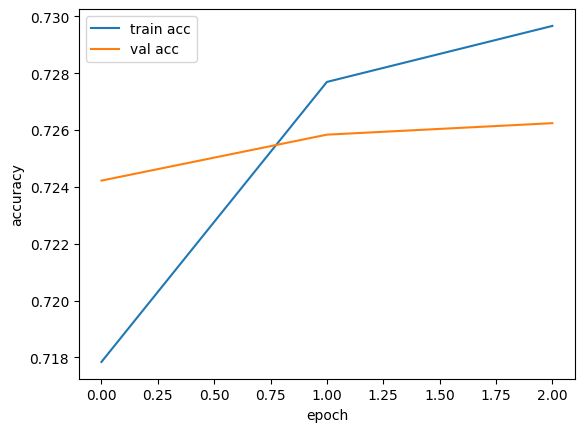

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history["train_acc"], label="train acc")
plt.plot(history["val_acc"], label="val acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [20]:
# Save model to drive to bypass future training requirements.
import os, json, torch

os.makedirs(MODEL_DIR, exist_ok=True)

# Save head weights
torch.save(head.state_dict(), os.path.join(MODEL_DIR, "head_state_dict.pt"))

# Save label mapping + any config to reproduce inference
meta = {
    "model_name": MODEL_NAME,
    "max_length": 2048,
    "label2id": label2id,
    "id2label": id2label,
    "hidden_size": encoder.config.hidden_size,
    "num_classes": len(label2id),
}
with open(os.path.join(MODEL_DIR, "metadata.json"), "w") as f:
    json.dump(meta, f, indent=2)

print("Saved to:", MODEL_DIR)

Saved to: /content/drive/MyDrive/uhn_models/model_4


## 5b. Load saved model

Need to first run cells 1, 2, 3, & 4

In [22]:
# if you want to omit training, load previously trained model.
import os, json, torch
from transformers import AutoTokenizer, AutoModelForMaskedLM

device = "cuda" if torch.cuda.is_available() else "cpu"

with open(os.path.join(MODEL_DIR, "metadata.json"), "r") as f:
    meta = json.load(f)

MODEL_NAME = meta["model_name"]
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
encoder = AutoModelForMaskedLM.from_pretrained(MODEL_NAME, trust_remote_code=True).to(device)
encoder.eval()
for p in encoder.parameters():
    p.requires_grad_(False)

# Recreate head with same dimensions/classes
head = VariantClassifier(meta["hidden_size"], meta["num_classes"]).to(device)
head.load_state_dict(torch.load(os.path.join(MODEL_DIR, "head_state_dict.pt"), map_location=device))
head.eval()

label2id = meta["label2id"]
id2label = {int(k): v for k, v in meta["id2label"].items()}  # json keys can come back as strings

# SAE v5
Train a token-level auto-encoder. This takes the 512 Hidden Dimension for any token, and embeds it in 4096-dimensional space (or whatever size space you specify).

We could also have a sequence-level autoencoder, which takes a 512 Vector (the average of each output neuron across all tokens), and again embeds it in 4096-dimensional space.

The token-level auto-encoder tells us which TOKENS have certain features. The sequence-level auto-encoder tells us which SEQUENCES have certain features.

## 1. Pre-Compute Activations
🚨WARNING!!🚨

You'll likely need a beefy GPU to run this, as we store all activations in the GPU to speed up training. For this training, I used approximately 70GB of GPU RAM. You can greatly reduce this requirement by lowering the sequence length or decreasing the number of samples

In [23]:
import torch
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

MAX_TOKENS = 352
LAYER_IDX = -2 # Layer of NTv2 to investigate. Uses python indexing
DTYPE_STORE = torch.float16 # Precision to use

encoder.eval()
for p in encoder.parameters():
    p.requires_grad_(False)

@torch.no_grad()
def precompute_Z_ids_mask(
    sequences,
    encoder,
    tokenizer,
    layer_idx,
    max_tokens=88,
    batch_size=64,
    device="cuda",
    store_dtype=torch.float16,
):
    """
    Returns:
      Z:  (N, max_tokens, hidden) on GPU
      IDs:(N, max_tokens) on GPU (int64)
      M:  (N, max_tokens) on GPU (bool)
    """
    N = len(sequences)
    H = encoder.config.hidden_size

    Z   = torch.empty((N, max_tokens, H), device=device, dtype=store_dtype)
    IDs = torch.empty((N, max_tokens), device=device, dtype=torch.long)
    M   = torch.empty((N, max_tokens), device=device, dtype=torch.bool)

    for i in tqdm(range(0, N, batch_size), desc="precompute Z/IDs/M"):
        seqs = sequences[i:i+batch_size]
        batch = tokenizer(
            seqs,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=max_tokens,
        )
        batch = {k: v.to(device) for k, v in batch.items()}

        out = encoder(**batch, output_hidden_states=True, return_dict=True)
        hs = out.hidden_states[layer_idx]          # (B, 88, 512)

        B = hs.size(0)
        Z[i:i+B]   = hs.to(dtype=store_dtype)
        IDs[i:i+B] = batch["input_ids"]
        M[i:i+B]   = batch["attention_mask"].bool()

    return Z, IDs, M


In [24]:
# idx_train are indices into `records` = (ref, alt, vtype, label)
train_seqs = []
train_meta = []  # (allele_kind, label_str, vtype, record_idx)

for i in idx_train:
    ref, alt, vtype, lab = records[i]
    train_seqs.append(ref)
    train_meta.append(("ref", lab, vtype, i))

for i in idx_train:
    ref, alt, vtype, lab = records[i]
    train_seqs.append(alt)
    train_meta.append(("alt", lab, vtype, i))

Z_train, IDs_train, M_train = precompute_Z_ids_mask(
    train_seqs, encoder, tokenizer,
    layer_idx=LAYER_IDX,
    max_tokens=MAX_TOKENS,
    batch_size=64,
    device=device,
    store_dtype=DTYPE_STORE,
)

X_train = Z_train.reshape(-1, Z_train.shape[-1])      # (N, 88, 512) -> (N*88, 512)
token_mask_flat = M_train.reshape(-1)                 # (N, 88) -> (N*88,)

print("Z_train:", Z_train.shape, Z_train.dtype)
print("X_train:", X_train.shape)
print("IDs_train:", IDs_train.shape)
print("valid tokens:", token_mask_flat.sum().item())


precompute Z/IDs/M:   0%|          | 0/619 [00:00<?, ?it/s]

Z_train: torch.Size([39566, 352, 1024]) torch.float16
X_train: torch.Size([13927232, 1024])
IDs_train: torch.Size([39566, 352])
valid tokens: 13610712


## 2. Define Autoencoder
Autoencoder also includes Encode, Decode, and Loss functions.

In [25]:
class SparseAutoencoder(torch.nn.Module):
    def __init__(self, d_in, d_hidden=2048, l1_coeff=1e-3):
        super().__init__()
        self.d_in = d_in
        self.d_hidden = d_hidden
        self.l1_coeff = l1_coeff

        self.enc = torch.nn.Linear(d_in, d_hidden, bias=True)
        self.dec = torch.nn.Linear(d_hidden, d_in, bias=True)

        # small weights
        torch.nn.init.normal_(self.enc.weight, std=0.02)
        torch.nn.init.zeros_(self.enc.bias)
        torch.nn.init.normal_(self.dec.weight, std=0.02)
        torch.nn.init.zeros_(self.dec.bias)

    def encode(self, x):
        return F.relu(self.enc(x))

    def decode(self, h):
        return self.dec(h)

    def forward(self, x):
        h = self.encode(x)
        x_hat = self.decode(h)
        return x_hat, h

    def loss(self, x, x_hat, h, l1_coeff=None):
        recon = F.mse_loss(x_hat, x)
        sparsity = h.abs().mean()
        return recon + l1_coeff * sparsity, recon.detach(), sparsity.detach() #loss, recon, l1



## 3a. Train Autoencoder

In [126]:
import math

def train_sae(
    X_train,
    token_mask_flat,
    d_hidden=2048,
    epochs=5,
    token_batch_size=4096,   # "sub-batch" size in token space. 4096 is very small, reccomend > 100,000.
    lr=1e-3,
    l1_warmup_frac=0.3,
    l1_coeff=1e-3,
    active_eps=1e-6,     # threshold for what we call an "active" neuron
    use_only_real_tokens=True,
):
    device = X_train.device
    d_in = X_train.shape[-1]
    curr_l1 = l1_coeff

    # Create encoder & optimizer
    sae = SparseAutoencoder(d_in=d_in, d_hidden=d_hidden, l1_coeff=l1_coeff).to(device)
    opt = torch.optim.AdamW(sae.parameters(), lr=lr, weight_decay=1e-4)

    # Build an index list once
    if use_only_real_tokens:
        idx = torch.nonzero(token_mask_flat, as_tuple=False).squeeze(1)
    else:
        idx = torch.arange(X_train.shape[0], device=device)

    print("training tokens:", idx.numel())

    # Iterate through all epochs
    sae.train()
    for ep in range(epochs):
        # shuffle token indices each epoch
        perm = idx[torch.randperm(idx.numel(), device=device)]

        # Metrics
        total_rcl = 0.0
        total_l1 = 0.0
        total_active = 0.0
        total_meanmax = 0.0
        steps = 0

        # Track whether each hidden unit has EVER been active this epoch
        ever_active = torch.zeros(d_hidden, device=device, dtype=torch.bool)

        pbar = tqdm(range(0, perm.numel(), token_batch_size), desc=f"SAE epoch {ep+1}/{epochs}") # Beautiful loading bars
        for s in pbar:
            batch_idx = perm[s:s+token_batch_size]
            x = X_train[batch_idx].float()   # compute in fp32 for stability
            opt.zero_grad(set_to_none=True)

            # Forward pass
            x_hat, h = sae(x)
            # Loss
            loss, rcl, l1 = sae.loss(x, x_hat, h, l1_coeff=curr_l1) #loss, reconstruction loss, l1

            loss.backward()
            opt.step()

            # ---- Metrics again ----
            active_mask = (h > active_eps)

            # Calculate avg # of active neurons per token in this batch
            active_per_token = (h > active_eps).float().sum(dim=1).mean()

            # Mean of max activation per token in this batch
            mean_max = h.max(dim=1).values.mean()

            # Update epoch-level dead-neuron tracker
            ever_active |= active_mask.any(dim=0)

            total_rcl += rcl.item()
            total_l1 += l1.item()
            total_active += active_per_token.item()
            total_meanmax += mean_max.item()
            steps += 1

            # Update loading bar
            if steps % 1 == 0:
                pbar.set_postfix(rcl=total_rcl/steps, l1=total_l1/steps, l1c=curr_l1)


        # ---- Epoch-level dead neuron fraction ----
        dead_frac = 1.0 - ever_active.float().mean().item()
        dead_units = (~ever_active).sum().item()

        if total_active/steps > 1000:
            curr_l1 = curr_l1 * 1.1 # Increase L1-coeff by 10% if 1k or more neurons on average are activated
            print(f'bumping up')
        elif total_active/steps > 500:
            curr_l1 = curr_l1 * 1.05 # Increase L1-coeff by 5% if 500 or more neurons on average are activated
            print(f'bumping up')
        elif total_active/steps > 300:
            curr_l1 = curr_l1 * 1.01 # Increase L1-coeff by 1% if 300 or more neurons on average are activated
            print(f'bumping up')

        print(f"epoch {ep+1}: rcl={total_rcl/steps:.6f}  l1={total_l1/steps:.6f}  active_units/token={total_active/steps:.2f}  mean_max_activation={total_meanmax/steps:.4f}  dead_units_frac={dead_frac:.3f}  dead_units={dead_units}/{d_hidden}")

    return sae


In [127]:
sae = train_sae(
    X_train=X_train,
    token_mask_flat=token_mask_flat,
    d_hidden=4096,
    epochs=100,
    token_batch_size=262144,
    lr=1e-4,
    l1_coeff=1,
    use_only_real_tokens=True,
)

# After 50 epoch w/o decorr, l1_coeff=5e-3:
# - 439 dead units
# - 857 active units / token
# - rcl 0.00061, l1 = 0.058

# After 50 epoch w/o decorr, l1_coeff=5e-2:
# Really great start! Then after 20 iter it fell off...
# -  894 dead units
# -  538 active units / token
# - rcl 0.000288, l1 = 0.0157


# Layer -4
# After 50 epoch w/o decorr, l1_coeff=5e-2:
# -  855 dead units
# -  848 active units / token
# - rcl 0.0053, l1 = 0.2017

# Layer -3
# After 150 epoch w/o decorr, l1_coeff=5e-3:, 2048 dim
# -  1339 dead units
# -  670 active units / token
# - rcl 0.007842 l1 = 0.645


# Layer -3
# After 50 epoch w/o decorr, l1_coeff=5e-3:, 4096 dim
# rcl=0.010722  l1=0.420676  active_units/token=953.55  mean_max_activation=10.7949  dead_units_frac=0.714  dead_units=2923/4096

# Layer -3
# After 150 epoch w/o decorr, lr = 1e-2, l1_coeff=5e-2:, 4096 dim
#

# Layer -3
# After 150 epoch w/o decorr, lr = 1e-4, l1_coeff=5e-4:, 4096 dim
#

# Super big model
#     token_batch_size=131072,
#    lr=1e-4,
#    l1_coeff=1e1
# very good!
# Setting l1_coeff to 1e2 works EVEN BETTER! Got it down to 100 activations with 40rcl

training tokens: 13610712


SAE epoch 1/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 1: rcl=105.838781  l1=3.356440  active_units/token=1945.15  mean_max_activation=31.5868  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 2/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 2: rcl=49.949559  l1=3.825811  active_units/token=2135.88  mean_max_activation=32.6719  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 3/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 3: rcl=30.634206  l1=4.419833  active_units/token=2412.43  mean_max_activation=33.4512  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 4/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 4: rcl=19.894719  l1=4.830710  active_units/token=2590.72  mean_max_activation=34.2307  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 5/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 5: rcl=13.770091  l1=4.922720  active_units/token=2671.89  mean_max_activation=34.1862  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 6/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 6: rcl=10.174958  l1=4.806106  active_units/token=2688.31  mean_max_activation=33.8311  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 7/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 7: rcl=7.993665  l1=4.580851  active_units/token=2663.70  mean_max_activation=33.4800  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 8/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 8: rcl=6.632587  l1=4.307442  active_units/token=2613.31  mean_max_activation=33.2643  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 9/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 9: rcl=5.768413  l1=4.018173  active_units/token=2546.13  mean_max_activation=33.2528  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 10/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 10: rcl=5.217373  l1=3.730356  active_units/token=2467.60  mean_max_activation=33.4843  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 11/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 11: rcl=4.870600  l1=3.453115  active_units/token=2381.29  mean_max_activation=33.9717  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 12/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 12: rcl=4.661523  l1=3.191018  active_units/token=2289.55  mean_max_activation=34.6975  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 13/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 13: rcl=4.546253  l1=2.946798  active_units/token=2194.40  mean_max_activation=35.6053  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 14/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 14: rcl=4.495757  l1=2.721611  active_units/token=2097.48  mean_max_activation=36.6158  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 15/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 15: rcl=4.490451  l1=2.515536  active_units/token=2000.26  mean_max_activation=37.6428  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 16/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 16: rcl=4.517064  l1=2.327926  active_units/token=1903.93  mean_max_activation=38.6139  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 17/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 17: rcl=4.567176  l1=2.157598  active_units/token=1809.61  mean_max_activation=39.4699  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 18/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 18: rcl=4.636535  l1=2.002900  active_units/token=1718.11  mean_max_activation=40.1686  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 19/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 19: rcl=4.723258  l1=1.862200  active_units/token=1630.24  mean_max_activation=40.6818  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 20/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 20: rcl=4.827037  l1=1.733906  active_units/token=1546.68  mean_max_activation=41.0003  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 21/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 21: rcl=4.948809  l1=1.616468  active_units/token=1467.85  mean_max_activation=41.1398  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 22/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 22: rcl=5.089867  l1=1.508540  active_units/token=1394.07  mean_max_activation=41.1174  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 23/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 23: rcl=5.251088  l1=1.408978  active_units/token=1325.33  mean_max_activation=40.9650  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 24/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 24: rcl=5.433588  l1=1.316762  active_units/token=1261.47  mean_max_activation=40.7002  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 25/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 25: rcl=5.638201  l1=1.231073  active_units/token=1202.14  mean_max_activation=40.3435  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 26/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 26: rcl=5.864714  l1=1.151255  active_units/token=1146.99  mean_max_activation=39.9097  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 27/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 27: rcl=6.114142  l1=1.076719  active_units/token=1095.56  mean_max_activation=39.4115  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 28/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 28: rcl=6.385829  l1=1.007069  active_units/token=1047.41  mean_max_activation=38.8613  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 29/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 29: rcl=6.681337  l1=0.941799  active_units/token=1002.10  mean_max_activation=38.2724  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 30/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 30: rcl=7.000568  l1=0.880614  active_units/token=959.30  mean_max_activation=37.6547  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 31/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 31: rcl=7.110949  l1=0.837183  active_units/token=932.63  mean_max_activation=36.9986  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 32/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 32: rcl=7.193790  l1=0.799175  active_units/token=910.64  mean_max_activation=36.3617  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 33/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 33: rcl=7.276914  l1=0.764163  active_units/token=890.82  mean_max_activation=35.7378  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 34/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 34: rcl=7.366037  l1=0.731460  active_units/token=872.51  mean_max_activation=35.1292  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 35/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 35: rcl=7.460594  l1=0.700780  active_units/token=855.35  mean_max_activation=34.5372  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 36/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 36: rcl=7.562513  l1=0.671843  active_units/token=839.15  mean_max_activation=33.9627  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 37/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 37: rcl=7.671788  l1=0.644462  active_units/token=823.73  mean_max_activation=33.4011  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 38/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 38: rcl=7.789517  l1=0.618469  active_units/token=808.98  mean_max_activation=32.8548  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 39/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 39: rcl=7.912953  l1=0.593821  active_units/token=794.76  mean_max_activation=32.3242  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 40/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 40: rcl=8.044052  l1=0.570353  active_units/token=781.04  mean_max_activation=31.8072  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 41/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 41: rcl=8.183442  l1=0.547974  active_units/token=767.75  mean_max_activation=31.2999  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 42/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 42: rcl=8.328541  l1=0.526639  active_units/token=754.80  mean_max_activation=30.8063  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 43/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 43: rcl=8.481737  l1=0.506253  active_units/token=742.14  mean_max_activation=30.3224  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 44/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 44: rcl=8.641876  l1=0.486780  active_units/token=729.76  mean_max_activation=29.8490  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 45/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 45: rcl=8.809017  l1=0.468147  active_units/token=717.58  mean_max_activation=29.3859  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 46/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 46: rcl=8.982690  l1=0.450315  active_units/token=705.62  mean_max_activation=28.9320  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 47/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 47: rcl=9.163057  l1=0.433232  active_units/token=693.86  mean_max_activation=28.4875  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 48/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 48: rcl=9.351384  l1=0.416836  active_units/token=682.23  mean_max_activation=28.0512  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 49/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 49: rcl=9.546012  l1=0.401136  active_units/token=670.70  mean_max_activation=27.6265  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 50/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 50: rcl=9.745597  l1=0.386086  active_units/token=659.34  mean_max_activation=27.2097  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 51/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 51: rcl=9.953540  l1=0.371613  active_units/token=648.05  mean_max_activation=26.8008  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 52/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 52: rcl=10.169022  l1=0.357735  active_units/token=636.86  mean_max_activation=26.4021  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 53/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 53: rcl=10.387017  l1=0.344433  active_units/token=625.82  mean_max_activation=26.0094  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 54/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 54: rcl=10.613688  l1=0.331645  active_units/token=614.85  mean_max_activation=25.6235  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 55/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 55: rcl=10.845726  l1=0.319360  active_units/token=603.96  mean_max_activation=25.2434  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 56/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 56: rcl=11.085548  l1=0.307539  active_units/token=593.10  mean_max_activation=24.8683  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 57/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 57: rcl=11.330707  l1=0.296209  active_units/token=582.29  mean_max_activation=24.5019  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 58/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 58: rcl=11.579177  l1=0.285326  active_units/token=571.60  mean_max_activation=24.1422  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 59/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 59: rcl=11.836603  l1=0.274851  active_units/token=560.93  mean_max_activation=23.7900  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 60/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 60: rcl=12.098559  l1=0.264794  active_units/token=550.34  mean_max_activation=23.4452  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 61/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 61: rcl=12.365834  l1=0.255125  active_units/token=539.82  mean_max_activation=23.1086  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 62/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 62: rcl=12.640044  l1=0.245835  active_units/token=529.33  mean_max_activation=22.7793  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 63/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 63: rcl=12.917108  l1=0.236914  active_units/token=518.95  mean_max_activation=22.4576  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 64/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 64: rcl=13.200333  l1=0.228342  active_units/token=508.63  mean_max_activation=22.1429  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 65/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 65: rcl=13.488129  l1=0.220108  active_units/token=498.40  mean_max_activation=21.8360  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 66/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 66: rcl=13.499920  l1=0.215331  active_units/token=497.08  mean_max_activation=21.5317  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 67/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 67: rcl=13.479099  l1=0.211238  active_units/token=496.91  mean_max_activation=21.2365  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 68/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 68: rcl=13.449762  l1=0.207453  active_units/token=497.02  mean_max_activation=20.9506  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 69/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 69: rcl=13.405929  l1=0.204006  active_units/token=497.49  mean_max_activation=20.6757  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 70/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 70: rcl=13.367031  l1=0.200678  active_units/token=497.80  mean_max_activation=20.4099  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 71/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 71: rcl=13.312831  l1=0.197647  active_units/token=498.54  mean_max_activation=20.1534  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 72/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 72: rcl=13.268222  l1=0.194681  active_units/token=499.12  mean_max_activation=19.9048  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 73/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 73: rcl=13.214521  l1=0.191880  active_units/token=499.88  mean_max_activation=19.6627  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 74/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 74: rcl=13.168427  l1=0.189183  active_units/token=500.49  mean_max_activation=19.4288  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 75/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 75: rcl=13.370113  l1=0.183996  active_units/token=492.76  mean_max_activation=19.2012  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 76/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 76: rcl=13.349631  l1=0.181113  active_units/token=492.42  mean_max_activation=18.9764  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 77/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 77: rcl=13.320547  l1=0.178485  active_units/token=492.66  mean_max_activation=18.7540  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 78/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 78: rcl=13.294707  l1=0.175951  active_units/token=492.89  mean_max_activation=18.5362  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 79/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 79: rcl=13.247152  l1=0.173583  active_units/token=493.38  mean_max_activation=18.3237  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 80/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 80: rcl=13.212217  l1=0.171294  active_units/token=493.87  mean_max_activation=18.1159  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 81/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 81: rcl=13.173753  l1=0.169086  active_units/token=494.42  mean_max_activation=17.9120  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 82/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 82: rcl=13.131962  l1=0.166921  active_units/token=494.91  mean_max_activation=17.7117  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 83/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 83: rcl=13.093918  l1=0.164850  active_units/token=495.49  mean_max_activation=17.5161  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 84/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 84: rcl=13.060126  l1=0.162807  active_units/token=495.95  mean_max_activation=17.3246  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 85/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 85: rcl=13.016237  l1=0.160841  active_units/token=496.55  mean_max_activation=17.1360  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 86/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 86: rcl=12.982599  l1=0.158916  active_units/token=496.99  mean_max_activation=16.9524  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 87/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 87: rcl=12.945052  l1=0.157039  active_units/token=497.53  mean_max_activation=16.7721  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 88/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 88: rcl=12.913947  l1=0.155183  active_units/token=497.94  mean_max_activation=16.5957  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 89/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 89: rcl=12.874762  l1=0.153389  active_units/token=498.48  mean_max_activation=16.4221  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 90/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 90: rcl=12.840419  l1=0.151652  active_units/token=498.91  mean_max_activation=16.2537  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 91/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 91: rcl=12.807966  l1=0.149922  active_units/token=499.38  mean_max_activation=16.0874  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 92/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 92: rcl=12.780249  l1=0.148208  active_units/token=499.70  mean_max_activation=15.9250  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 93/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 93: rcl=12.750925  l1=0.146543  active_units/token=500.09  mean_max_activation=15.7658  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 94/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 94: rcl=12.945422  l1=0.143086  active_units/token=492.46  mean_max_activation=15.6120  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 95/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 95: rcl=12.939456  l1=0.141234  active_units/token=491.96  mean_max_activation=15.4584  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 96/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 96: rcl=12.940605  l1=0.139472  active_units/token=491.66  mean_max_activation=15.3070  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 97/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 97: rcl=12.922116  l1=0.137846  active_units/token=491.73  mean_max_activation=15.1593  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 98/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 98: rcl=12.896232  l1=0.136293  active_units/token=491.85  mean_max_activation=15.0154  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 99/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 99: rcl=12.880805  l1=0.134727  active_units/token=491.96  mean_max_activation=14.8738  dead_units_frac=0.000  dead_units=0/4096


SAE epoch 100/100:   0%|          | 0/52 [00:00<?, ?it/s]

bumping up
epoch 100: rcl=12.866538  l1=0.133208  active_units/token=491.96  mean_max_activation=14.7348  dead_units_frac=0.000  dead_units=0/4096


### retroactively graph training curve
Using output from training above, graph the training curve.

In [44]:
import re, pandas as pd, matplotlib.pyplot as plt

raw = r"""
SAE epoch 1/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=3.36, l1c=1, rcl=106]
bumping up
epoch 1: rcl=105.838781  l1=3.356440  active_units/token=1945.15  mean_max_activation=31.5868  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 2/100: 100%
 52/52 [00:34<00:00,  1.54it/s, l1=3.83, l1c=1.1, rcl=49.9]
bumping up
epoch 2: rcl=49.949559  l1=3.825811  active_units/token=2135.88  mean_max_activation=32.6719  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 3/100: 100%
 52/52 [00:34<00:00,  1.54it/s, l1=4.42, l1c=1.21, rcl=30.6]
bumping up
epoch 3: rcl=30.634206  l1=4.419833  active_units/token=2412.43  mean_max_activation=33.4512  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 4/100: 100%
 52/52 [00:34<00:00,  1.54it/s, l1=4.83, l1c=1.33, rcl=19.9]
bumping up
epoch 4: rcl=19.894719  l1=4.830710  active_units/token=2590.72  mean_max_activation=34.2307  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 5/100: 100%
 52/52 [00:34<00:00,  1.54it/s, l1=4.92, l1c=1.46, rcl=13.8]
bumping up
epoch 5: rcl=13.770091  l1=4.922720  active_units/token=2671.89  mean_max_activation=34.1862  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 6/100: 100%
 52/52 [00:34<00:00,  1.54it/s, l1=4.81, l1c=1.61, rcl=10.2]
bumping up
epoch 6: rcl=10.174958  l1=4.806106  active_units/token=2688.31  mean_max_activation=33.8311  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 7/100: 100%
 52/52 [00:34<00:00,  1.54it/s, l1=4.58, l1c=1.77, rcl=7.99]
bumping up
epoch 7: rcl=7.993665  l1=4.580851  active_units/token=2663.70  mean_max_activation=33.4800  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 8/100: 100%
 52/52 [00:34<00:00,  1.54it/s, l1=4.31, l1c=1.95, rcl=6.63]
bumping up
epoch 8: rcl=6.632587  l1=4.307442  active_units/token=2613.31  mean_max_activation=33.2643  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 9/100: 100%
 52/52 [00:34<00:00,  1.54it/s, l1=4.02, l1c=2.14, rcl=5.77]
bumping up
epoch 9: rcl=5.768413  l1=4.018173  active_units/token=2546.13  mean_max_activation=33.2528  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 10/100: 100%
 52/52 [00:34<00:00,  1.54it/s, l1=3.73, l1c=2.36, rcl=5.22]
bumping up
epoch 10: rcl=5.217373  l1=3.730356  active_units/token=2467.60  mean_max_activation=33.4843  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 11/100: 100%
 52/52 [00:34<00:00,  1.54it/s, l1=3.45, l1c=2.59, rcl=4.87]
bumping up
epoch 11: rcl=4.870600  l1=3.453115  active_units/token=2381.29  mean_max_activation=33.9717  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 12/100: 100%
 52/52 [00:34<00:00,  1.54it/s, l1=3.19, l1c=2.85, rcl=4.66]
bumping up
epoch 12: rcl=4.661523  l1=3.191018  active_units/token=2289.55  mean_max_activation=34.6975  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 13/100: 100%
 52/52 [00:34<00:00,  1.54it/s, l1=2.95, l1c=3.14, rcl=4.55]
bumping up
epoch 13: rcl=4.546253  l1=2.946798  active_units/token=2194.40  mean_max_activation=35.6053  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 14/100: 100%
 52/52 [00:34<00:00,  1.54it/s, l1=2.72, l1c=3.45, rcl=4.5]
bumping up
epoch 14: rcl=4.495757  l1=2.721611  active_units/token=2097.48  mean_max_activation=36.6158  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 15/100: 100%
 52/52 [00:34<00:00,  1.54it/s, l1=2.52, l1c=3.8, rcl=4.49]
bumping up
epoch 15: rcl=4.490451  l1=2.515536  active_units/token=2000.26  mean_max_activation=37.6428  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 16/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=2.33, l1c=4.18, rcl=4.52]
bumping up
epoch 16: rcl=4.517064  l1=2.327926  active_units/token=1903.93  mean_max_activation=38.6139  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 17/100: 100%
 52/52 [00:34<00:00,  1.54it/s, l1=2.16, l1c=4.59, rcl=4.57]
bumping up
epoch 17: rcl=4.567176  l1=2.157598  active_units/token=1809.61  mean_max_activation=39.4699  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 18/100: 100%
 52/52 [00:34<00:00,  1.54it/s, l1=2, l1c=5.05, rcl=4.64]
bumping up
epoch 18: rcl=4.636535  l1=2.002900  active_units/token=1718.11  mean_max_activation=40.1686  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 19/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=1.86, l1c=5.56, rcl=4.72]
bumping up
epoch 19: rcl=4.723258  l1=1.862200  active_units/token=1630.24  mean_max_activation=40.6818  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 20/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=1.73, l1c=6.12, rcl=4.83]
bumping up
epoch 20: rcl=4.827037  l1=1.733906  active_units/token=1546.68  mean_max_activation=41.0003  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 21/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=1.62, l1c=6.73, rcl=4.95]
bumping up
epoch 21: rcl=4.948809  l1=1.616468  active_units/token=1467.85  mean_max_activation=41.1398  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 22/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=1.51, l1c=7.4, rcl=5.09]
bumping up
epoch 22: rcl=5.089867  l1=1.508540  active_units/token=1394.07  mean_max_activation=41.1174  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 23/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=1.41, l1c=8.14, rcl=5.25]
bumping up
epoch 23: rcl=5.251088  l1=1.408978  active_units/token=1325.33  mean_max_activation=40.9650  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 24/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=1.32, l1c=8.95, rcl=5.43]
bumping up
epoch 24: rcl=5.433588  l1=1.316762  active_units/token=1261.47  mean_max_activation=40.7002  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 25/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=1.23, l1c=9.85, rcl=5.64]
bumping up
epoch 25: rcl=5.638201  l1=1.231073  active_units/token=1202.14  mean_max_activation=40.3435  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 26/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=1.15, l1c=10.8, rcl=5.86]
bumping up
epoch 26: rcl=5.864714  l1=1.151255  active_units/token=1146.99  mean_max_activation=39.9097  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 27/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=1.08, l1c=11.9, rcl=6.11]
bumping up
epoch 27: rcl=6.114142  l1=1.076719  active_units/token=1095.56  mean_max_activation=39.4115  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 28/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=1.01, l1c=13.1, rcl=6.39]
bumping up
epoch 28: rcl=6.385829  l1=1.007069  active_units/token=1047.41  mean_max_activation=38.8613  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 29/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=0.942, l1c=14.4, rcl=6.68]
bumping up
epoch 29: rcl=6.681337  l1=0.941799  active_units/token=1002.10  mean_max_activation=38.2724  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 30/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=0.881, l1c=15.9, rcl=7]
bumping up
epoch 30: rcl=7.000568  l1=0.880614  active_units/token=959.30  mean_max_activation=37.6547  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 31/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=0.837, l1c=16.7, rcl=7.11]
bumping up
epoch 31: rcl=7.110949  l1=0.837183  active_units/token=932.63  mean_max_activation=36.9986  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 32/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=0.799, l1c=17.5, rcl=7.19]
bumping up
epoch 32: rcl=7.193790  l1=0.799175  active_units/token=910.64  mean_max_activation=36.3617  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 33/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=0.764, l1c=18.4, rcl=7.28]
bumping up
epoch 33: rcl=7.276914  l1=0.764163  active_units/token=890.82  mean_max_activation=35.7378  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 34/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=0.731, l1c=19.3, rcl=7.37]
bumping up
epoch 34: rcl=7.366037  l1=0.731460  active_units/token=872.51  mean_max_activation=35.1292  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 35/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=0.701, l1c=20.2, rcl=7.46]
bumping up
epoch 35: rcl=7.460594  l1=0.700780  active_units/token=855.35  mean_max_activation=34.5372  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 36/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=0.672, l1c=21.3, rcl=7.56]
bumping up
epoch 36: rcl=7.562513  l1=0.671843  active_units/token=839.15  mean_max_activation=33.9627  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 37/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=0.644, l1c=22.3, rcl=7.67]
bumping up
epoch 37: rcl=7.671788  l1=0.644462  active_units/token=823.73  mean_max_activation=33.4011  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 38/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=0.618, l1c=23.4, rcl=7.79]
bumping up
epoch 38: rcl=7.789517  l1=0.618469  active_units/token=808.98  mean_max_activation=32.8548  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 39/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.594, l1c=24.6, rcl=7.91]
bumping up
epoch 39: rcl=7.912953  l1=0.593821  active_units/token=794.76  mean_max_activation=32.3242  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 40/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.57, l1c=25.8, rcl=8.04]
bumping up
epoch 40: rcl=8.044052  l1=0.570353  active_units/token=781.04  mean_max_activation=31.8072  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 41/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=0.548, l1c=27.1, rcl=8.18]
bumping up
epoch 41: rcl=8.183442  l1=0.547974  active_units/token=767.75  mean_max_activation=31.2999  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 42/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=0.527, l1c=28.5, rcl=8.33]
bumping up
epoch 42: rcl=8.328541  l1=0.526639  active_units/token=754.80  mean_max_activation=30.8063  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 43/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=0.506, l1c=29.9, rcl=8.48]
bumping up
epoch 43: rcl=8.481737  l1=0.506253  active_units/token=742.14  mean_max_activation=30.3224  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 44/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.487, l1c=31.4, rcl=8.64]
bumping up
epoch 44: rcl=8.641876  l1=0.486780  active_units/token=729.76  mean_max_activation=29.8490  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 45/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.468, l1c=33, rcl=8.81]
bumping up
epoch 45: rcl=8.809017  l1=0.468147  active_units/token=717.58  mean_max_activation=29.3859  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 46/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.45, l1c=34.6, rcl=8.98]
bumping up
epoch 46: rcl=8.982690  l1=0.450315  active_units/token=705.62  mean_max_activation=28.9320  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 47/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.433, l1c=36.4, rcl=9.16]
bumping up
epoch 47: rcl=9.163057  l1=0.433232  active_units/token=693.86  mean_max_activation=28.4875  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 48/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=0.417, l1c=38.2, rcl=9.35]
bumping up
epoch 48: rcl=9.351384  l1=0.416836  active_units/token=682.23  mean_max_activation=28.0512  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 49/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=0.401, l1c=40.1, rcl=9.55]
bumping up
epoch 49: rcl=9.546012  l1=0.401136  active_units/token=670.70  mean_max_activation=27.6265  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 50/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=0.386, l1c=42.1, rcl=9.75]
bumping up
epoch 50: rcl=9.745597  l1=0.386086  active_units/token=659.34  mean_max_activation=27.2097  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 51/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=0.372, l1c=44.2, rcl=9.95]
bumping up
epoch 51: rcl=9.953540  l1=0.371613  active_units/token=648.05  mean_max_activation=26.8008  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 52/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.358, l1c=46.4, rcl=10.2]
bumping up
epoch 52: rcl=10.169022  l1=0.357735  active_units/token=636.86  mean_max_activation=26.4021  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 53/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.344, l1c=48.7, rcl=10.4]
bumping up
epoch 53: rcl=10.387017  l1=0.344433  active_units/token=625.82  mean_max_activation=26.0094  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 54/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.332, l1c=51.2, rcl=10.6]
bumping up
epoch 54: rcl=10.613688  l1=0.331645  active_units/token=614.85  mean_max_activation=25.6235  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 55/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.319, l1c=53.7, rcl=10.8]
bumping up
epoch 55: rcl=10.845726  l1=0.319360  active_units/token=603.96  mean_max_activation=25.2434  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 56/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.308, l1c=56.4, rcl=11.1]
bumping up
epoch 56: rcl=11.085548  l1=0.307539  active_units/token=593.10  mean_max_activation=24.8683  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 57/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.296, l1c=59.2, rcl=11.3]
bumping up
epoch 57: rcl=11.330707  l1=0.296209  active_units/token=582.29  mean_max_activation=24.5019  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 58/100: 100%
 52/52 [00:34<00:00,  1.55it/s, l1=0.285, l1c=62.2, rcl=11.6]
bumping up
epoch 58: rcl=11.579177  l1=0.285326  active_units/token=571.60  mean_max_activation=24.1422  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 59/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.275, l1c=65.3, rcl=11.8]
bumping up
epoch 59: rcl=11.836603  l1=0.274851  active_units/token=560.93  mean_max_activation=23.7900  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 60/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.265, l1c=68.6, rcl=12.1]
bumping up
epoch 60: rcl=12.098559  l1=0.264794  active_units/token=550.34  mean_max_activation=23.4452  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 61/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.255, l1c=72, rcl=12.4]
bumping up
epoch 61: rcl=12.365834  l1=0.255125  active_units/token=539.82  mean_max_activation=23.1086  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 62/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.246, l1c=75.6, rcl=12.6]
bumping up
epoch 62: rcl=12.640044  l1=0.245835  active_units/token=529.33  mean_max_activation=22.7793  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 63/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.237, l1c=79.4, rcl=12.9]
bumping up
epoch 63: rcl=12.917108  l1=0.236914  active_units/token=518.95  mean_max_activation=22.4576  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 64/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.228, l1c=83.3, rcl=13.2]
bumping up
epoch 64: rcl=13.200333  l1=0.228342  active_units/token=508.63  mean_max_activation=22.1429  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 65/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.22, l1c=87.5, rcl=13.5]
bumping up
epoch 65: rcl=13.488129  l1=0.220108  active_units/token=498.40  mean_max_activation=21.8360  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 66/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.215, l1c=88.4, rcl=13.5]
bumping up
epoch 66: rcl=13.499920  l1=0.215331  active_units/token=497.08  mean_max_activation=21.5317  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 67/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.211, l1c=89.3, rcl=13.5]
bumping up
epoch 67: rcl=13.479099  l1=0.211238  active_units/token=496.91  mean_max_activation=21.2365  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 68/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.207, l1c=90.2, rcl=13.4]
bumping up
epoch 68: rcl=13.449762  l1=0.207453  active_units/token=497.02  mean_max_activation=20.9506  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 69/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.204, l1c=91.1, rcl=13.4]
bumping up
epoch 69: rcl=13.405929  l1=0.204006  active_units/token=497.49  mean_max_activation=20.6757  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 70/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.201, l1c=92, rcl=13.4]
bumping up
epoch 70: rcl=13.367031  l1=0.200678  active_units/token=497.80  mean_max_activation=20.4099  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 71/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.198, l1c=92.9, rcl=13.3]
bumping up
epoch 71: rcl=13.312831  l1=0.197647  active_units/token=498.54  mean_max_activation=20.1534  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 72/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.195, l1c=93.8, rcl=13.3]
bumping up
epoch 72: rcl=13.268222  l1=0.194681  active_units/token=499.12  mean_max_activation=19.9048  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 73/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.192, l1c=94.8, rcl=13.2]
bumping up
epoch 73: rcl=13.214521  l1=0.191880  active_units/token=499.88  mean_max_activation=19.6627  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 74/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.189, l1c=95.7, rcl=13.2]
bumping up
epoch 74: rcl=13.168427  l1=0.189183  active_units/token=500.49  mean_max_activation=19.4288  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 75/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.184, l1c=100, rcl=13.4]
bumping up
epoch 75: rcl=13.370113  l1=0.183996  active_units/token=492.76  mean_max_activation=19.2012  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 76/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.181, l1c=101, rcl=13.3]
bumping up
epoch 76: rcl=13.349631  l1=0.181113  active_units/token=492.42  mean_max_activation=18.9764  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 77/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.178, l1c=103, rcl=13.3]
bumping up
epoch 77: rcl=13.320547  l1=0.178485  active_units/token=492.66  mean_max_activation=18.7540  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 78/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.176, l1c=104, rcl=13.3]
bumping up
epoch 78: rcl=13.294707  l1=0.175951  active_units/token=492.89  mean_max_activation=18.5362  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 79/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.174, l1c=105, rcl=13.2]
bumping up
epoch 79: rcl=13.247152  l1=0.173583  active_units/token=493.38  mean_max_activation=18.3237  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 80/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.171, l1c=106, rcl=13.2]
bumping up
epoch 80: rcl=13.212217  l1=0.171294  active_units/token=493.87  mean_max_activation=18.1159  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 81/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.169, l1c=107, rcl=13.2]
bumping up
epoch 81: rcl=13.173753  l1=0.169086  active_units/token=494.42  mean_max_activation=17.9120  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 82/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.167, l1c=108, rcl=13.1]
bumping up
epoch 82: rcl=13.131962  l1=0.166921  active_units/token=494.91  mean_max_activation=17.7117  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 83/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.165, l1c=109, rcl=13.1]
bumping up
epoch 83: rcl=13.093918  l1=0.164850  active_units/token=498.48  mean_max_activation=16.4221  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 84/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.163, l1c=110, rcl=13.1]
bumping up
epoch 84: rcl=13.060126  l1=0.162807  active_units/token=495.95  mean_max_activation=17.3246  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 85/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.161, l1c=111, rcl=13]
bumping up
epoch 85: rcl=13.016237  l1=0.160841  active_units/token=496.55  mean_max_activation=17.1360  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 86/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.159, l1c=112, rcl=13]
bumping up
epoch 86: rcl=12.982599  l1=0.158916  active_units/token=496.99  mean_max_activation=16.9524  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 87/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.157, l1c=113, rcl=12.9]
bumping up
epoch 87: rcl=12.945052  l1=0.157039  active_units/token=497.53  mean_max_activation=16.7721  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 88/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.155, l1c=114, rcl=12.9]
bumping up
epoch 88: rcl=12.913947  l1=0.155183  active_units/token=497.94  mean_max_activation=16.5957  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 89/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.153, l1c=116, rcl=12.9]
bumping up
epoch 89: rcl=12.874762  l1=0.153389  active_units/token=498.48  mean_max_activation=16.4221  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 90/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.152, l1c=117, rcl=12.8]
bumping up
epoch 90: rcl=12.840419  l1=0.151652  active_units/token=498.91  mean_max_activation=16.2537  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 91/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.15, l1c=118, rcl=12.8]
bumping up
epoch 91: rcl=12.807966  l1=0.149922  active_units/token=499.38  mean_max_activation=16.0874  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 92/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.148, l1c=119, rcl=12.8]
bumping up
epoch 92: rcl=12.780249  l1=0.148208  active_units/token=499.70  mean_max_activation=15.9250  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 93/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.147, l1c=120, rcl=12.8]
bumping up
epoch 93: rcl=12.750925  l1=0.146543  active_units/token=500.09  mean_max_activation=15.7658  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 94/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.143, l1c=126, rcl=12.9]
bumping up
epoch 94: rcl=12.945422  l1=0.143086  active_units/token=492.46  mean_max_activation=15.6120  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 95/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.141, l1c=127, rcl=12.9]
bumping up
epoch 95: rcl=12.939456  l1=0.141234  active_units/token=491.96  mean_max_activation=15.4584  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 96/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.139, l1c=129, rcl=12.9]
bumping up
epoch 96: rcl=12.940605  l1=0.139472  active_units/token=491.66  mean_max_activation=15.3070  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 97/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.138, l1c=130, rcl=12.9]
bumping up
epoch 97: rcl=12.922116  l1=0.137846  active_units/token=491.73  mean_max_activation=15.1593  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 98/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.136, l1c=131, rcl=12.9]
bumping up
epoch 98: rcl=12.896232  l1=0.136293  active_units/token=491.85  mean_max_activation=15.0154  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 99/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.135, l1c=133, rcl=12.9]
bumping up
epoch 99: rcl=12.880805  l1=0.134727  active_units/token=491.96  mean_max_activation=14.8738  dead_units_frac=0.000  dead_units=0/4096
SAE epoch 100/100: 100%
 52/52 [00:34<00:00,  1.56it/s, l1=0.133, l1c=134, rcl=12.9]
bumping up
epoch 100: rcl=12.866538  l1=0.133208  active_units/token=491.96  mean_max_activation=14.7348  dead_units_frac=0.000  dead_units=0/4096
"""

pattern = re.compile(r"epoch\s+(\d+):\s*rcl=([0-9.]+)\s+l1=([0-9.]+)")
rows = [(int(e), float(rcl), float(l1)) for e, rcl, l1 in pattern.findall(raw)]
df = pd.DataFrame(rows, columns=["epoch", "rcl", "l1"]).sort_values("epoch").reset_index(drop=True)

# basic sanity check
count = len(df)
missing = sorted(set(range(1, 101)) - set(df["epoch"].tolist()))

count, missing[:10], df.head(), df.tail()


(100,
 [],
    epoch         rcl        l1
 0      1  105.838781  3.356440
 1      2   49.949559  3.825811
 2      3   30.634206  4.419833
 3      4   19.894719  4.830710
 4      5   13.770091  4.922720,
     epoch        rcl        l1
 95     96  12.940605  0.139472
 96     97  12.922116  0.137846
 97     98  12.896232  0.136293
 98     99  12.880805  0.134727
 99    100  12.866538  0.133208)

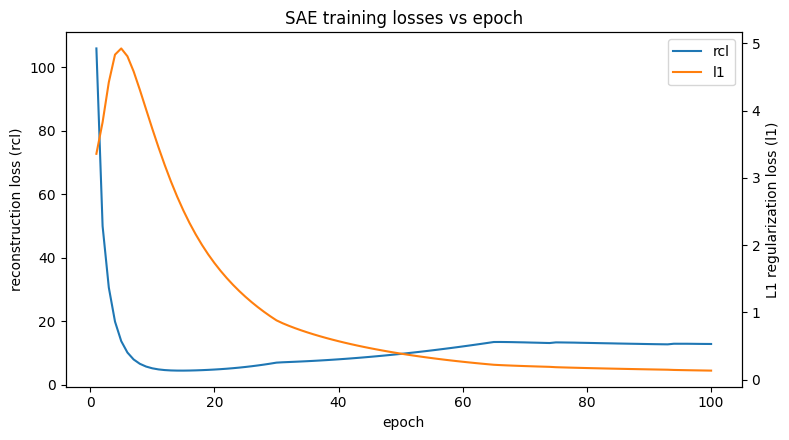

In [55]:
# Make a simple plot with two y-axes (same x).
fig, ax1 = plt.subplots(figsize=(8,4.5))
ax1.plot(df["epoch"], df["rcl"], label="rcl", color="C0")
ax1.set_xlabel("epoch")
ax1.set_ylabel("reconstruction loss (rcl)")
ax2 = ax1.twinx()
ax2.plot(df["epoch"], df["l1"], label="l1", color="C1")
ax2.set_ylabel("L1 regularization loss (l1)")
ax1.set_title("SAE training losses vs epoch")

# Build a combined legend (matplotlib defaults)
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="best")

png_path = "/content/images/sae_losses_plot.png"
fig.tight_layout()
fig.savefig(png_path, dpi=200)
plt.show()


In [128]:
# Save model
import os, json, torch

SAE_DIR  = os.path.join(MODEL_DIR, "sae") # Nested inside MODEL_DIR
os.makedirs(SAE_DIR, exist_ok=True)

# Save SAE weights
torch.save(sae.state_dict(), os.path.join(SAE_DIR, "sae_state_dict.pt"))

# Save minimal metadata needed to reconstruct SAE
sae_meta = {
    "d_in": sae.d_in,
    "d_hidden": sae.d_hidden,
    "l1_coeff": sae.l1_coeff
}
with open(os.path.join(SAE_DIR, "sae_metadata.json"), "w") as f:
    json.dump(sae_meta, f, indent=2)

print("Saved SAE to:", SAE_DIR)

Saved SAE to: /content/drive/MyDrive/uhn_models/model_4/sae


## 3b. Load Autoencoder

In [26]:
# Load SAE model
import os, json, torch

device = "cuda" if torch.cuda.is_available() else "cpu"

SAE_DIR = os.path.join(MODEL_DIR, "sae")

# Load metadata needed to reconstruct the SAE module
with open(os.path.join(SAE_DIR, "sae_metadata.json"), "r") as f:
    sae_meta = json.load(f)

# Recreate SAE with the same constructor args you used originally
sae = SparseAutoencoder(
    d_in=sae_meta["d_in"],
    d_hidden=sae_meta["d_hidden"],
    l1_coeff=sae_meta["l1_coeff"],
).to(device)

# 3) Load weights
state_dict_path = os.path.join(SAE_DIR, "sae_state_dict.pt")
sae.load_state_dict(torch.load(state_dict_path, map_location=device))

# 4) Set eval b/c we're using it for inference
sae.eval()
for p in sae.parameters():
    p.requires_grad_(False)

print("Loaded SAE from:", SAE_DIR)

Loaded SAE from: /content/drive/MyDrive/uhn_models/model_4/sae


# Interpretability (understandable)

## 1. Understanding what causes each feature to fire

In [27]:
def topk_feature_tokens(
    sae,
    X_flat,                  # (N*88, 512) on GPU (fp16 ok)
    token_mask_flat,         # (N*88,) bool on GPU
    feature_idx: int,
    top_k: int = 50,
    chunk_size: int = 65536,
):
    """
    For a given feature in the encoder, what are the top tokens that activate it?
    Returns:
      top_vals: (top_k,) activation values
      top_idx:  (top_k,) flattened token indices into X_flat
    """
    device = X_flat.device

    # Grab weight row + bias for this feature
    # nn.Linear weight shape: (d_hidden, d_in)
    w = sae.enc.weight[feature_idx].detach().to(device).float()  # (512,)
    b = sae.enc.bias[feature_idx].detach().to(device).float()    # scalar

    best_vals = torch.full((top_k,), -1e9, device=device, dtype=torch.float32)
    best_idx  = torch.full((top_k,), -1,   device=device, dtype=torch.long)

    N = X_flat.shape[0]
    for start in tqdm(range(0, N, chunk_size), desc=f"scan feature {feature_idx}"):
        end = min(start + chunk_size, N)
        x = X_flat[start:end].float()                       # (C, 512)
        m = token_mask_flat[start:end]                      # (C,)

        # a = relu(x@w + b)
        a = x.matmul(w) + b                                 # (C,)
        a = torch.relu(a)
        a = a.masked_fill(~m, -1e9)                         # ignore pad tokens

        vals, idx = torch.topk(a, k=min(top_k, a.numel()))
        idx = idx + start

        merged_vals = torch.cat([best_vals, vals])
        merged_idx  = torch.cat([best_idx, idx])

        best_vals, sel = torch.topk(merged_vals, k=top_k)
        best_idx = merged_idx[sel]

    return best_vals, best_idx

def flat_to_sample_token(flat_idx: int, seq_len: int = 88):
    sample_idx = flat_idx // seq_len
    tok_idx = flat_idx % seq_len
    return int(sample_idx), int(tok_idx)

def token_window_str(IDs_train, sample_idx, tok_idx, tokenizer, radius=4):
    ids = IDs_train[sample_idx].tolist()
    toks = tokenizer.convert_ids_to_tokens(ids)
    lo = max(0, tok_idx - radius)
    hi = min(len(toks), tok_idx + radius + 1)
    window = toks[lo:hi]
    return " ".join(window), (lo, hi)


In [28]:
feature_idx = 1581
top_vals, top_idx = topk_feature_tokens(
    sae, X_train, token_mask_flat,
    feature_idx=feature_idx,
    top_k=25,
    chunk_size=65536,
)

for rank in range(10):
    fi = int(top_idx[rank].item())
    val = float(top_vals[rank].item())
    sidx, tidx = flat_to_sample_token(fi, seq_len=MAX_TOKENS)

    allele_kind, lab, vtype, rec_i = train_meta[sidx]
    win, (lo, hi) = token_window_str(IDs_train, sidx, tidx, tokenizer, radius=4)

    print(f"[{rank:02d}] act={val:.4f} | {allele_kind} | {lab} | {vtype} | record={rec_i} | tok={tidx} | window: {win}")


scan feature 1581:   0%|          | 0/213 [00:00<?, ?it/s]

[00] act=30.9337 | ref | Likely_benign | single_nucleotide_variant | record=3383 | tok=34 | window: TGCAGA AGACGC TGGAGC AGTTCC ACCTGA GCTCCA TGAGCT CGCTGG GCGGCC
[01] act=30.9050 | alt | Likely_benign | single_nucleotide_variant | record=3385 | tok=33 | window: TGCAGA AGACGC TGGAGC AGTTCC ACCTGA GCTCCA TGAGCT CGCTGG GCGGCC
[02] act=30.8653 | alt | Likely_benign | single_nucleotide_variant | record=3383 | tok=34 | window: TGCAGA AGACGC TGGAGC AGTTCC ACCTGA GCTCCA TGAGCT CGCTGG GCGGCC
[03] act=30.8632 | alt | Likely_benign | single_nucleotide_variant | record=3387 | tok=32 | window: TGCAGA AGACGC TGGAGC AGTTCC ACCTGA GCTCCA TGAGCT CGCTGG GCGGCC
[04] act=30.8517 | alt | Likely_pathogenic | single_nucleotide_variant | record=1954 | tok=171 | window: ACGTGC TCTCGG CCGACC TGGTGC ACTAGC TGCGCC TCAGCC GCGACT ACCTGC
[05] act=30.8422 | ref | Likely_benign | single_nucleotide_variant | record=3387 | tok=32 | window: TGCAGA AGACGC TGGAGC AGTTCC ACCTGA GCTCCA TGAGCT CGCTGG GCGGCC
[06] act=30.8304 

## 2. Per-Sequence Feature Scores

In [29]:
import torch
from tqdm.auto import tqdm

@torch.no_grad()
def compute_feature_scores_per_sample(
    sae,
    Z,              # (N, L, 512) on GPU (fp16 ok)
    M,              # (N, L) bool on GPU
    sample_chunk=128,
):
    """
    Tells us the average activation of the SAE for each feature across all tokens.
    Turns (N, L, D) -> (N, H)

    N: Number of Samples
    L: Length of sequence
    D: Dimension before auto-encoder
    H: Number of neurons in auto-encoder

    Returns:
      S: (N, H) float32 on GPU
    """
    device = Z.device
    N, L, D = Z.shape
    H = sae.d_hidden
    S = torch.empty((N, H), device=device, dtype=torch.float32)

    for i in tqdm(range(0, N, sample_chunk), desc="compute per-sample feature scores"):
        j = min(i + sample_chunk, N)
        z = Z[i:j].float()              # (B, L, D)
        m = M[i:j]                      # (B, L)

        # Flatten tokens -> encode -> reshape back
        x = z.reshape(-1, D)        # (B*L, D)
        h = sae.encode(x)           # (B*L, H)
        h = h.reshape(-1, L, H)     # (B, L, H)

        # masked mean over tokens
        mask = m.unsqueeze(-1).float()  # (B, L, 1)
        h_sum = (h * mask).sum(dim=1)   # (B, H)
        denom = mask.sum(dim=1).clamp(min=1.0)  # (B, 1)
        S[i:j] = h_sum / denom

    return S
print(f'Z_train shape: {Z_train.shape}')

S_train = compute_feature_scores_per_sample(sae, Z_train, M_train, sample_chunk=128)
print("S_train:", S_train.shape, S_train.dtype, S_train.device)


Z_train shape: torch.Size([39566, 352, 1024])


compute per-sample feature scores:   0%|          | 0/310 [00:00<?, ?it/s]

S_train: torch.Size([39566, 4096]) torch.float32 cuda:0


In [30]:
# Classifies into benign(ish) and pathogenic(ish) w/ array g
benign_set = {"Benign", "Likely_benign"}
path_set   = {"Pathogenic", "Likely_pathogenic"}


# group vector g: 0=benign(ish), 1=pathogenic(ish), -1=ignore
g = torch.full((len(train_meta),), -1, device=device, dtype=torch.long)

for i, (_, lab, _, _) in enumerate(train_meta):
    if lab in benign_set:
        g[i] = 0
    elif lab in path_set:
        g[i] = 1

keep = (g != -1)
print("kept sequences:", keep.sum().item(), "/", keep.numel())

is_alt = torch.tensor([m[0] == "alt" for m in train_meta], device=device)
keep = keep & is_alt
print("kept ALT sequences:", keep.sum().item())


kept sequences: 39566 / 39566
kept ALT sequences: 19783


In [31]:
@torch.no_grad()
def cohens_d(a, b, eps=1e-6):
    """
    Finds which features in autoencoder which are most distinct (on average) between sets A and B.
    In our case, this finds the features that are most differently activated in pathogenic and non-pathogenic samples.

    The goal is to figure out which features change the most between the groups, hopefully letting us find a "pathogenic" neuron.

    N_a : Number of samples in group A
    N_b : Number of samples in group B
    H  : Number of neurons in autoencoder

    a: (N_a, H), b: (N_b, H)
    returns: (H,) effect size
    """
    ma = a.mean(dim=0)
    mb = b.mean(dim=0)
    va = a.var(dim=0, unbiased=False)
    vb = b.var(dim=0, unbiased=False)
    pooled = torch.sqrt(0.5 * (va + vb) + eps)
    return (mb - ma) / pooled  # positive => higher in group b

S_use = S_train[keep]
g_use = g[keep]

S_ben = S_use[g_use == 0]
S_pat = S_use[g_use == 1]
print("benign(ish):", S_ben.shape, "pathogenic(ish):", S_pat.shape)

d = cohens_d(S_ben, S_pat)  # (H,)
top_k = 10
vals, feats = torch.topk(d.abs(), k=top_k)

print("Top features by |Cohen's d|:")
for rank in range(top_k):
    f = int(feats[rank].item())
    print(f"#{rank:02d} feature={f}  d={float(d[f].item()):+.3f}")

#0.44 when 1e-3
#0.339 when 1e-2
#0.372 when 1e-3 & decorr
#0.323 when 1e-2, 50-iter

benign(ish): torch.Size([17418, 4096]) pathogenic(ish): torch.Size([2365, 4096])
Top features by |Cohen's d|:
#00 feature=1581  d=-0.404
#01 feature=1683  d=-0.395
#02 feature=578  d=-0.326
#03 feature=2080  d=-0.310
#04 feature=3295  d=-0.295
#05 feature=2492  d=-0.289
#06 feature=681  d=+0.283
#07 feature=3772  d=-0.280
#08 feature=2678  d=+0.273
#09 feature=3379  d=-0.272


In [32]:
def group_means_for_feature(S_train, g, feature_idx, mask):
    """
    Finds means for mb (benign(ish)) and mp (pathogenic(ish))
    """
    S = S_train[mask, feature_idx]
    gg = g[mask]
    mb = S[gg == 0].mean().item()
    mp = S[gg == 1].mean().item()
    return mb, mp

for f in feats[:5].tolist():  # Get top 5 features which vary most btwn benigh(ish) & pathogenic(ish)
    f = int(f)
    mb, mp = group_means_for_feature(S_train, g, f, keep)
    print("\n" + "="*80)
    print(f"Feature {f} | mean benign-ish={mb:.4f} | mean pathogenic-ish={mp:.4f} | d={float(d[f].item()):+.3f}")

    top_vals, top_idx = topk_feature_tokens(
        sae,
        X_train, token_mask_flat,
        feature_idx=f,
        top_k=15,
        chunk_size=65536
    )

    for rank in range(8):
        fi = int(top_idx[rank].item())
        val = float(top_vals[rank].item())
        sidx, tidx = flat_to_sample_token(fi, seq_len=MAX_TOKENS)

        allele_kind, lab, vtype, rec_i = train_meta[sidx]
        win, _ = token_window_str(IDs_train, sidx, tidx, tokenizer, radius=4)

        print(f"[{rank:02d}] act={val:.4f} | {allele_kind} | {lab} | {vtype} | record={rec_i} | tok={tidx} | {win}")



Feature 1581 | mean benign-ish=1.0227 | mean pathogenic-ish=0.4935 | d=-0.404


scan feature 1581:   0%|          | 0/213 [00:00<?, ?it/s]

[00] act=30.9337 | ref | Likely_benign | single_nucleotide_variant | record=3383 | tok=34 | TGCAGA AGACGC TGGAGC AGTTCC ACCTGA GCTCCA TGAGCT CGCTGG GCGGCC
[01] act=30.9050 | alt | Likely_benign | single_nucleotide_variant | record=3385 | tok=33 | TGCAGA AGACGC TGGAGC AGTTCC ACCTGA GCTCCA TGAGCT CGCTGG GCGGCC
[02] act=30.8653 | alt | Likely_benign | single_nucleotide_variant | record=3383 | tok=34 | TGCAGA AGACGC TGGAGC AGTTCC ACCTGA GCTCCA TGAGCT CGCTGG GCGGCC
[03] act=30.8632 | alt | Likely_benign | single_nucleotide_variant | record=3387 | tok=32 | TGCAGA AGACGC TGGAGC AGTTCC ACCTGA GCTCCA TGAGCT CGCTGG GCGGCC
[04] act=30.8517 | alt | Likely_pathogenic | single_nucleotide_variant | record=1954 | tok=171 | ACGTGC TCTCGG CCGACC TGGTGC ACTAGC TGCGCC TCAGCC GCGACT ACCTGC
[05] act=30.8422 | ref | Likely_benign | single_nucleotide_variant | record=3387 | tok=32 | TGCAGA AGACGC TGGAGC AGTTCC ACCTGA GCTCCA TGAGCT CGCTGG GCGGCC
[06] act=30.8304 | alt | Likely_benign | single_nucleotide_varian

scan feature 1683:   0%|          | 0/213 [00:00<?, ?it/s]

[00] act=44.6700 | alt | Pathogenic | single_nucleotide_variant | record=24170 | tok=171 | TCAGTG AGCCGC CCGACT TCCCCT TTTGAT TCTCCC CTGCTC AGTTCA CCGGCC
[01] act=43.3195 | alt | Likely_benign | single_nucleotide_variant | record=24174 | tok=165 | TCAGTG AGCCGC CCGACT TCCCCT TTTGGT TCTCCC CTGCTC AGTTCA CCGGCC
[02] act=43.1426 | ref | Likely_benign | single_nucleotide_variant | record=24169 | tok=173 | TCAGTG AGCCGC CCGACT TCCCCT TTTGGT TCTCCC CTGCTC AGTTCA CCGGCC
[03] act=43.0557 | ref | Likely_benign | single_nucleotide_variant | record=24174 | tok=165 | TCAGTG AGCCGC CCGACT TCCCCT TTTGGT TCTCCC CTGCTC AGTTCA CCGGCC
[04] act=43.0548 | ref | Pathogenic | single_nucleotide_variant | record=24170 | tok=171 | TCAGTG AGCCGC CCGACT TCCCCT TTTGGT TCTCCC CTGCTC AGTTCA CCGGCC
[05] act=43.0192 | alt | Likely_benign | single_nucleotide_variant | record=24169 | tok=173 | TCAGTG AGCCGC CCGATT TCCCCT TTTGGT TCTCCC CTGCTC AGTTCA CCGGCC
[06] act=42.8628 | ref | Benign | single_nucleotide_variant | re

scan feature 578:   0%|          | 0/213 [00:00<?, ?it/s]

[00] act=44.8062 | ref | Benign | single_nucleotide_variant | record=3072 | tok=186 | GGATCA GCCAGG CGGCGG TGCCCG CCAGGG TGTCTC TAGGTA CGGGGC CTCGCC
[01] act=44.7888 | alt | Likely_benign | single_nucleotide_variant | record=3087 | tok=124 | CCTTCT GGATCA GCCAGG CGGCGG TGCCCG CCAGGG TGTCTC TAGGTA CGGGGC
[02] act=44.4757 | ref | Benign | single_nucleotide_variant | record=3072 | tok=185 | CCTTCT GGATCA GCCAGG CGGCGG TGCCCG CCAGGG TGTCTC TAGGTA CGGGGC
[03] act=44.4228 | alt | Benign | single_nucleotide_variant | record=3081 | tok=172 | GGATCA GCCAGG CGGCGG TGCCTG CCAGGG TGTCTC TAGGTA CGGGGC CTCGCC
[04] act=44.3949 | alt | Benign | single_nucleotide_variant | record=3072 | tok=185 | CCTTCT GGATCA GCCAGG CGGCGG TGCCCG CCAGGG TGTCTC TAGGTA CGGGGC
[05] act=44.3894 | alt | Likely_benign | single_nucleotide_variant | record=3115 | tok=75 | TCCAAT CCTACA TGCCCT CCGTCC TGCTGG TCGCCA TGTCCT GGGTCT CCTTCT
[06] act=44.3828 | alt | Likely_benign | single_nucleotide_variant | record=3087 | tok=117 | 

scan feature 2080:   0%|          | 0/213 [00:00<?, ?it/s]

[00] act=44.1653 | ref | Likely_benign | single_nucleotide_variant | record=2407 | tok=5 | CGTCCG AGTCCA CAAAGC TGCTGG ACTCAA GCTCGC TGCTGA GGGCGG TGGACG
[01] act=44.1085 | alt | Likely_benign | single_nucleotide_variant | record=2407 | tok=5 | CGTCCG AGTCCA CAAAGC TGCTGG ACTCAA GCTCGC TGCTGA GGGCGG TGGACG
[02] act=43.4815 | alt | Likely_benign | single_nucleotide_variant | record=16901 | tok=107 | CGATGT CAGCGA ACTTGG GGCGGC GGGCAC GCTCCT GCTGCC AGCACT GCATCA
[03] act=43.4723 | ref | Likely_benign | single_nucleotide_variant | record=16901 | tok=107 | CGATGT CAGCGA ACTTGG GGCGGC GGGCAC GCTCCT GCTGCC AGCACT GCATCA
[04] act=43.2782 | ref | Likely_benign | Microsatellite | record=2162 | tok=186 | AGAAGG TGATCT TGTTGA CCGTGT GCCGCA GGAAGC CGTGCT TCAGCA AGCTGC
[05] act=43.2461 | alt | Benign | single_nucleotide_variant | record=16897 | tok=161 | CGATGT CAGCGA ACTTGG GGCGGC GGGCAC GCTCCT GCTGCC AGCACT GCATCA
[06] act=43.2097 | ref | Likely_benign | single_nucleotide_variant | record=2167 | 

scan feature 3295:   0%|          | 0/213 [00:00<?, ?it/s]

[00] act=6.8505 | ref | Likely_benign | single_nucleotide_variant | record=16976 | tok=175 | GGTCGC TCACTG TCACAC TGGTGC GGGTCA GTCCGT GAGGAG GCTCCG AGTAGC
[01] act=6.8281 | ref | Likely_benign | single_nucleotide_variant | record=16982 | tok=152 | GGTCGC TCACTG TCACAC TGGTGC GGGTCA GTCCGT GAGGAG GCTCCG AGTAGC
[02] act=6.7534 | alt | Likely_benign | single_nucleotide_variant | record=16976 | tok=175 | GGTCAC TCACTG TCACAC TGGTGC GGGTCA GTCCGT GAGGAG GCTCCG AGTAGC
[03] act=6.7415 | alt | Likely_benign | single_nucleotide_variant | record=16982 | tok=152 | GGTCGC TCACTG TCACAC TGGTGC GGGTCA GTCCGT GAGGAG GCTCCG AGTAGC
[04] act=6.5891 | alt | Benign | Deletion | record=21888 | tok=175 | TTCTAC CCTTTT CAGAAA GGCCTA AAGAAT GTATTT GACGAA GCAATA TTGGCT
[05] act=6.5166 | ref | Likely_benign | single_nucleotide_variant | record=2460 | tok=50 | CATGCA CCGGCG GTCAGA GAGAAA CAGAAC ACGGCA GGGAGT TTCACA AATGTT
[06] act=6.5111 | alt | Likely_benign | single_nucleotide_variant | record=2460 | tok=50 |

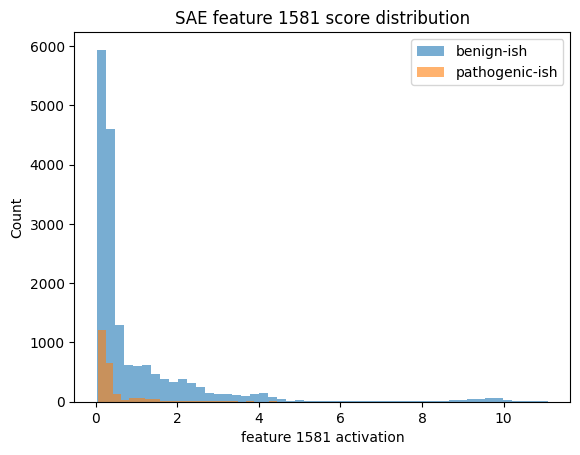

In [33]:
import matplotlib.pyplot as plt

feature_to_plot = int(feats[0].item())

s = S_train[keep, feature_to_plot].detach().float().cpu()
gg = g[keep].detach().cpu()

plt.figure()
plt.hist(s[gg==0].numpy(), bins=50, alpha=0.6, label="benign-ish")
plt.hist(s[gg==1].numpy(), bins=50, alpha=0.6, label="pathogenic-ish")
plt.title(f"SAE feature {feature_to_plot} score distribution")
plt.ylabel(f"Count")
plt.xlabel(f"feature {feature_to_plot} activation")
plt.legend()
plt.show()


## 3. Visualizing Selected Neurons

In [34]:
import torch

@torch.no_grad()
def feature_activation_per_token(
    sae,
    Z,          # (N, L, 512)
    M,          # (N, L) bool
    sample_idx: int,
    feature_idx: int,
):
    """
    Helps compute the activation of a given feature for each token in a specified sample
    Returns:
      act: (L,) float32 on GPU
    """
    z = Z[sample_idx].float()                 # (L, 512)
    m = M[sample_idx]                         # (L,)

    w = sae.enc.weight[feature_idx].detach().float()  # (512,)
    b = sae.enc.bias[feature_idx].detach().float()    # scalar

    act = torch.relu(z @ w + b)               # (L,)
    act = act.masked_fill(~m, float("nan"))   # ignore padding tokens nicely for plotting
    return act

def nan_safe_argmax_1d(x: torch.Tensor) -> int:
    """
    x: (L,) tensor, may contain NaNs
    returns Python int index of max, ignoring NaNs
    """
    x2 = torch.nan_to_num(x, nan=-1e9)  # or -float("inf") if you prefer
    return int(torch.argmax(x2).item())


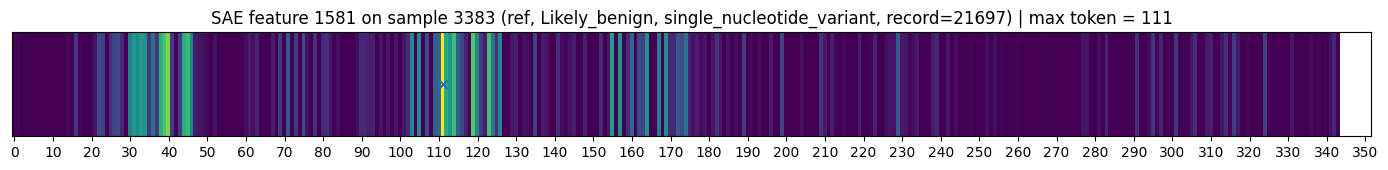

In [66]:
import matplotlib.pyplot as plt
import torch

def plot_feature_heatmap(
    act,              # (L,) tensor (NaNs on pads OK)
    title="",
    tick_every=4,
):
    """
    Creates 1D-Heatmap from activations
    """
    act_cpu = act.detach().cpu().unsqueeze(0)  # (1, L)

    plt.figure(figsize=(14, 1.8))
    plt.imshow(act_cpu, aspect="auto")
    plt.yticks([])

    L = act_cpu.shape[1]
    xticks = list(range(0, L, tick_every))
    plt.xticks(xticks, xticks)

    max_pos = nan_safe_argmax_1d(act)
    plt.scatter([max_pos], [0], marker="x")
    plt.title(f"{title} | max token = {max_pos}")
    plt.tight_layout()
    plt.show()


# ---- Single Sample Visualization ----
sample_idx = 3383    # pick a sequence index in train_seqs
feature_idx = 1581    # pick an SAE feature (helpful to chose top feature from section 2)

act = feature_activation_per_token(sae, Z_train, M_train, sample_idx, feature_idx)

allele_kind, lab, vtype, rec_i = train_meta[sample_idx]
plot_feature_heatmap(
    act,
    title=f"SAE feature {feature_idx} on sample {sample_idx} ({allele_kind}, {lab}, {vtype}, record={rec_i})",
    tick_every=10,
)


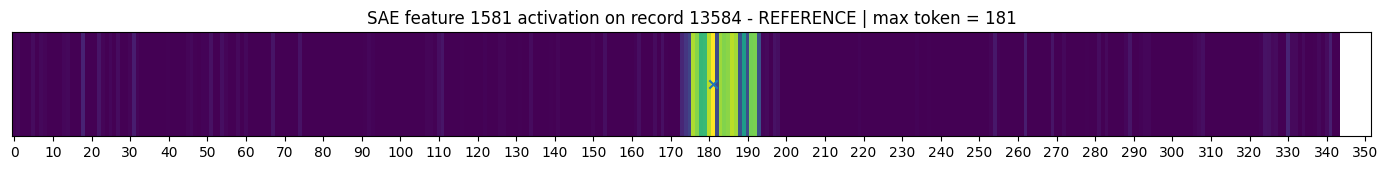

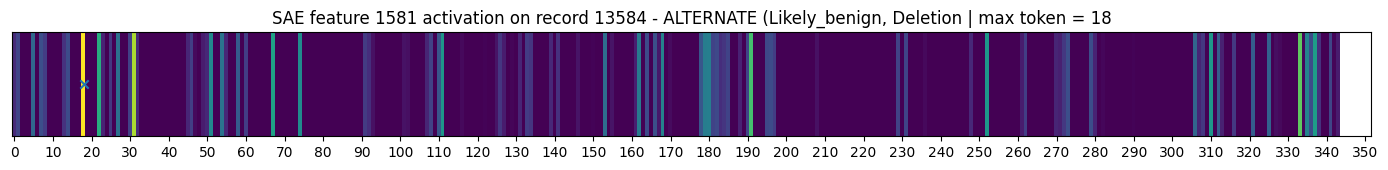

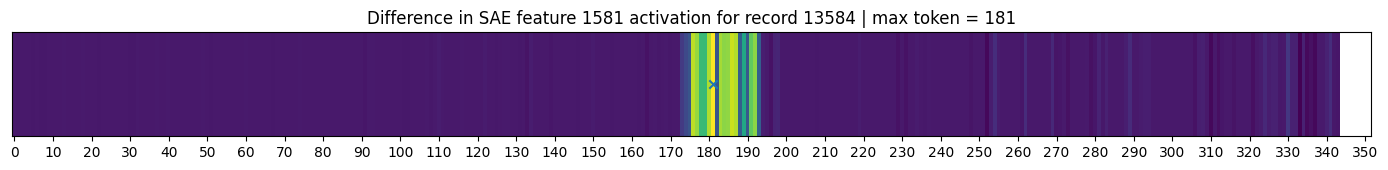

In [74]:
# ---- Compare activatinos across REF & ALT ----
sample_idx = 4    # pick a sequence index in train_seqs
feature_idx = 1581    # pick an SAE feature (helpful to chose top feature from section 2)

act = feature_activation_per_token(sae, Z_train, M_train, sample_idx, feature_idx)

allele_kind, lab, vtype, rec_i = train_meta[sample_idx]
plot_feature_heatmap(
    act,
    title=f"SAE feature {feature_idx} activation on record {rec_i} - REFERENCE",
    tick_every=10,
)

sample_idx += 19783
act_2 = feature_activation_per_token(sae, Z_train, M_train, sample_idx, feature_idx)
allele_kind, lab, vtype, rec_i = train_meta[sample_idx]
plot_feature_heatmap(
    act_2,
    title=f"SAE feature {feature_idx} activation on record {rec_i} - ALTERNATE ({lab}, {vtype}",
    tick_every=10,
)

plot_feature_heatmap(
    act - act_2,
    title=f"Difference in SAE feature {feature_idx} activation for record {rec_i}",
    tick_every=10,
)

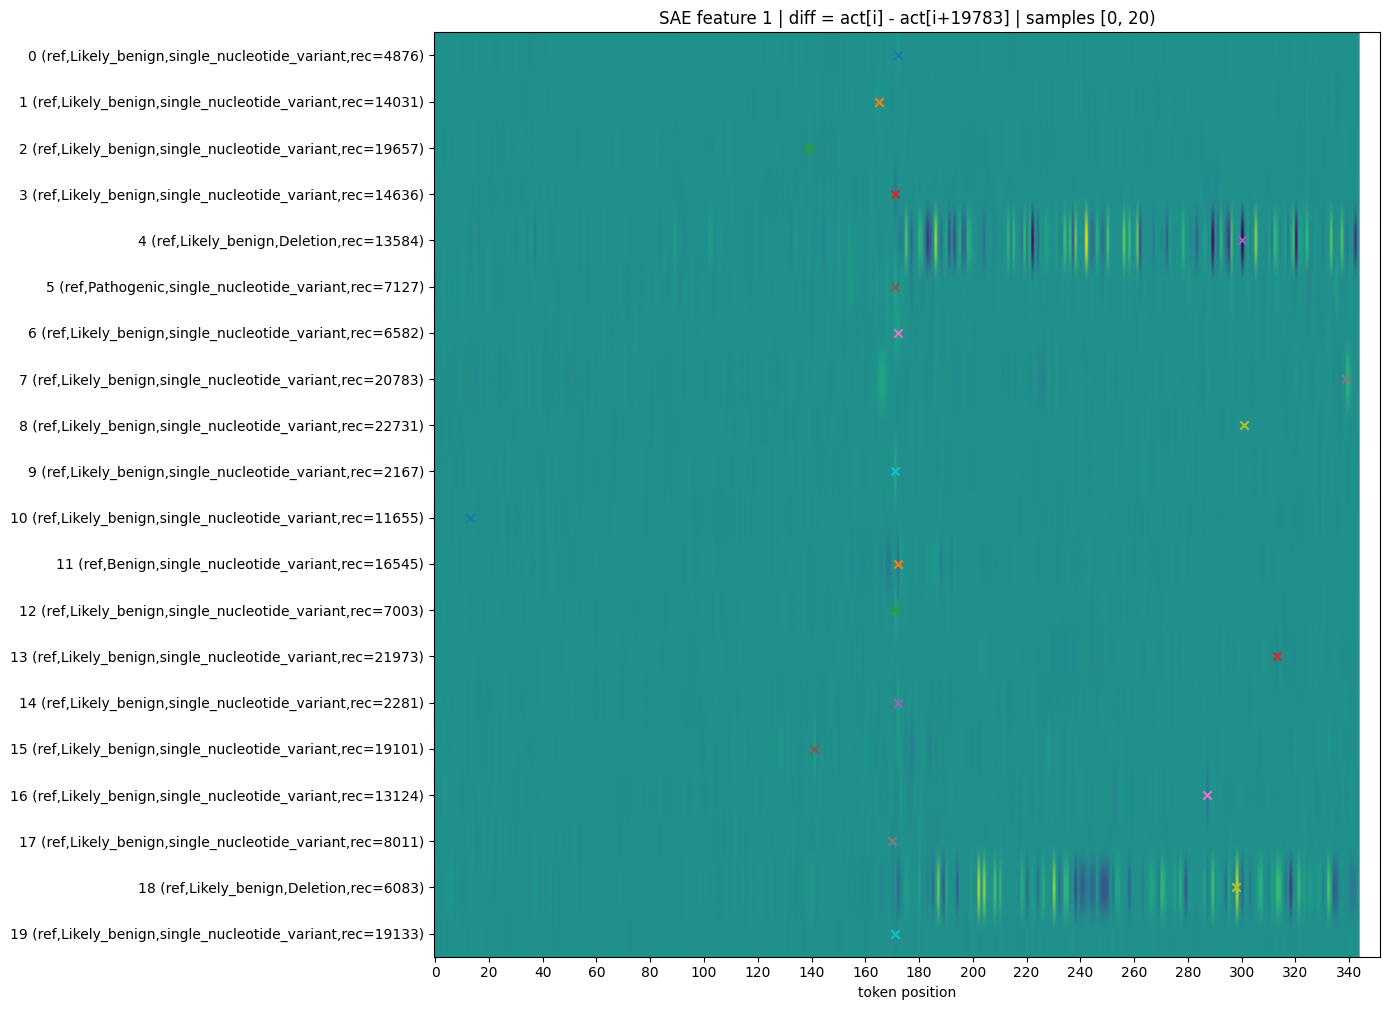

In [85]:
import matplotlib.pyplot as plt
import torch

def nan_safe_argmax_1d(x: torch.Tensor) -> int:
    x = x.detach().clone()
    if x.numel() == 0:
        return 0
    nan_mask = torch.isnan(x)
    if nan_mask.all():
        return 0
    x[nan_mask] = -float("inf")
    return int(torch.argmax(x).item())

def nan_safe_absmax(x: torch.Tensor) -> float:
    """
    Returns max(abs(x)) ignoring NaNs/Infs. Falls back to 1.0 if nothing finite.
    Compatible with older PyTorch (no torch.nanmax).
    """
    x = x.detach()
    finite = torch.isfinite(x)  # usually available even in fairly old torch
    if finite.any():
        m = torch.max(torch.abs(x[finite]))
        m_val = float(m.item())
        return m_val if m_val != 0.0 else 1.0
    return 1.0

def feature_activation_diff_per_token(
    sae, Z, M,
    sample_idx: int,
    feature_idx: int,
    offset: int = 19783,
):
    a = feature_activation_per_token(sae, Z, M, sample_idx, feature_idx)
    b = feature_activation_per_token(sae, Z, M, sample_idx + offset, feature_idx)
    return a - b

def plot_feature_diff_heatmaps_range(
    sae, Z, M,
    train_meta,
    sample_start: int,
    sample_end_exclusive: int,
    feature_idx: int,
    offset: int = 19783,
    tick_every: int = 4,
    label_every: int | None = None,
    use_abs_for_marker: bool = True,
    title_prefix: str = "",
):
    sample_indices = list(range(sample_start, sample_end_exclusive))

    diffs = []
    lengths = []
    for i in sample_indices:
        d = feature_activation_diff_per_token(sae, Z, M, i, feature_idx, offset=offset)
        diffs.append(d.detach().cpu())
        lengths.append(d.numel())

    maxL = max(lengths) if lengths else 0
    diff_mat = torch.full((len(diffs), maxL), float("nan"))
    for r, d in enumerate(diffs):
        diff_mat[r, : d.numel()] = d

    # --- FIX: no torch.nanmax ---
    absmax = nan_safe_absmax(diff_mat)

    fig_h = max(2.5, 0.45 * len(sample_indices) + 1.2)
    plt.figure(figsize=(14, fig_h))
    plt.imshow(diff_mat, aspect="auto", vmin=-absmax, vmax=absmax)

    if label_every is None:
        label_every = 1 if len(sample_indices) <= 25 else max(1, len(sample_indices) // 25)

    yticks = list(range(0, len(sample_indices), label_every))
    ylabels = []
    for r in yticks:
        i = sample_indices[r]
        allele_kind, lab, vtype, rec_i = train_meta[i]
        ylabels.append(f"{i} ({allele_kind},{lab},{vtype},rec={rec_i})")
    plt.yticks(yticks, ylabels)

    xticks = list(range(0, maxL, tick_every))
    plt.xticks(xticks, xticks)

    for r, d in enumerate(diffs):
        max_pos = nan_safe_argmax_1d(torch.abs(d) if use_abs_for_marker else d)
        plt.scatter([max_pos], [r], marker="x")

    plt.title(
        f"{title_prefix}SAE feature {feature_idx} | diff = act[i] - act[i+{offset}] "
        f"| samples [{sample_start}, {sample_end_exclusive})"
    )
    plt.xlabel("token position")
    plt.tight_layout()
    plt.show()


# ---- usage ----
feature_idx = 1 # Neuron index in autoencoder
plot_feature_diff_heatmaps_range(
    sae, Z_train, M_train,
    train_meta=train_meta,
    sample_start=0,
    sample_end_exclusive=20,
    feature_idx=feature_idx,
    offset=19783,
    tick_every=20,
)

#00 feature=1581  d=-0.404
#01 feature=1683  d=-0.395
#02 feature=578  d=-0.326
#03 feature=2080  d=-0.310
#04 feature=3295  d=-0.295
#05 feature=2492  d=-0.289
#06 feature=681  d=+0.283
#07 feature=3772  d=-0.280
#08 feature=2678  d=+0.273
#09 feature=3379  d=-0.272

# 145-148 has splicing parts!

# Finale

Sources:
- CSC413, CSC311
- Interpretability in LLMs from [Claude](https://transformer-circuits.pub/2024/scaling-monosemanticity/).
- Interpretability is like looking through a [telescope](https://transformer-circuits.pub/2024/july-update/index.html#dark-matter).
- Helpful [youtube video](https://www.youtube.com/watch?v=UGO_Ehywuxc) on mechanistic interpretability.

TWO BIG GOALS:
- Determine which regions of a given DNA sequence are most strongly associated with being pathogenic
- See if altering the network's behavior actually changes the predicted pathogenicity. See if you can turn a prediction into being more pathogenic / less pathogenic.

Interpretability ideas:
- Look at vtypes and see if we consistently mislabel on certain variant types?
- See if you can find a "missense" block on your network, or something like that. Then, let the user PLAY with those blocks! Like make the inputs maximally missense, etc. Then make sure that those outputs actually are maximally missense.
- Big goal: identify parts of a DNA sequence that are most vulnerable to becoming pathogenic. Which regions of the DNA are most sensitive to being mutated and then CAUSING a pathogenic variation?
  - See if those vulnerable DNA sequences have special annotations, like DNA-Binding domain or something.
  - Would be super cool to be able to find a vulnerable region, then have some way to explain WHY that region is vulnerable. "We found region A to be vulnerable, and based on our mechanistic understanding of the model, it believes this region is vulnerable because it activates the DNA-Binding neurons and the close-to-start-sequence neurons."
- See if you can find a "DNA-Binding" set of activations or something.
- Highlight regions of interest (Called CAM and grad-CAM) (Class-Activation-Mapping)
- Make variants that are MORE non-pathogenic than others!
- Check Integrated Gradients method


Telescope
- Check G-C concentration vs A-T concentration, see if associated w/ diseases?

Ideas:
- Check NTV3 with [this](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://proceedings.neurips.cc/paper_files/paper/2024/file/f2b86cbc0b3e31dd001aeb516afbe1e2-Paper-Datasets_and_Benchmarks_Track.pdf) paper. Possibly switch to this model.
  - Compare NTv2 with NTv3 pre (no functional annotations) and NTv3 post (with functional annotations)
- Compare interpretability of many different models.
- Look at gradient across different examples. See what regions are most important.
  - Select a gene you know a little about and provide explanation
- Do train / validation / test split based on gene locus to prevent data leakage
- Try allowing the base model to update as well when training classifier head. Compare weights of base model with newly fine-tuned model. Evaluate performance of base model.
- Grab a few mutations that cause a difference to the protein's structure, versus mutations which cause a difference to a regulatory element, etc. See if you can extract some sort of "mutation type" neuron.
- Compare your classifier head with a trained classifier WITHOUT the NTv2 backbone, see if it does better
- Check training accuracy as size of context window increases


Debugging:
- Double check last_ref and last_out are ACTUALLY the final layers of the network

Limitations:
- Training, Test, Validation NOT split by gene locus (possible data leakage)
- Do more evaluation, see exactly WHERE our model fails.

# Model Guide
### Model 1
- 50m NTv2, 50,000 samples, L4 GPU, 512 seq length, 5epoch classifier, 50epoch SAE
### Model 2
- 50m NTv2, 100,000 samples, L4 GPU, 1024 seq length, 10epoch, 100epoch SAE

### Model 4
- 500m NTv2, 50,000 samples, A100 GPU, 2048 seq length, 3epoch, 100epoch SAE


In [88]:
import numpy as np
import matplotlib.pyplot as plt

def heatmap_square(x, shape=(64, 64), clip_percentile=99.5, cmap=None, title=None):
    """
    Plot a square heatmap from a single sample.

    Parameters
    ----------
    x : array-like or torch.Tensor, shape (D,)
        The sample to visualize.
    shape : tuple
        Heatmap shape. Default (64, 64) must multiply to D.
    clip_percentile : float or None
        Robust clipping based on percentile of |x|. Set None for no clipping.
    cmap : str or None
        Colormap override. If None: coolwarm for signed data, viridis for nonnegative.
    title : str or None
        Optional plot title.
    """
    # Convert to numpy 1D
    if hasattr(x, "detach"):  # torch.Tensor
        x = x.detach().float().cpu().numpy()
    else:
        x = np.asarray(x, dtype=np.float32)

    x = x.reshape(-1)
    assert np.prod(shape) == x.shape[0], f"shape={shape} must multiply to {x.shape[0]}"

    # Choose colormap
    if cmap is None:
        cmap = "coolwarm" if (x.min() < 0 and x.max() > 0) else "viridis"

    # Robust color limits
    if clip_percentile is not None:
        lim = np.percentile(np.abs(x), clip_percentile)
        if x.min() < 0 and x.max() > 0:
            vmin, vmax = -lim, lim
        else:
            vmin, vmax = 0.0, lim
    else:
        vmin, vmax = float(x.min()), float(x.max())

    img = x.reshape(shape)

    plt.figure(figsize=(6.5, 5.5))
    plt.imshow(img, aspect="auto", interpolation="nearest", cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(label="activation")
    plt.title(title or f"512 → {shape[0]}×{shape[1]} heatmap")
    plt.xlabel("col")
    plt.ylabel("row")
    plt.tight_layout()
    plt.show()

S_train shape: torch.Size([4096])
Z_train shape: torch.Size([1024])


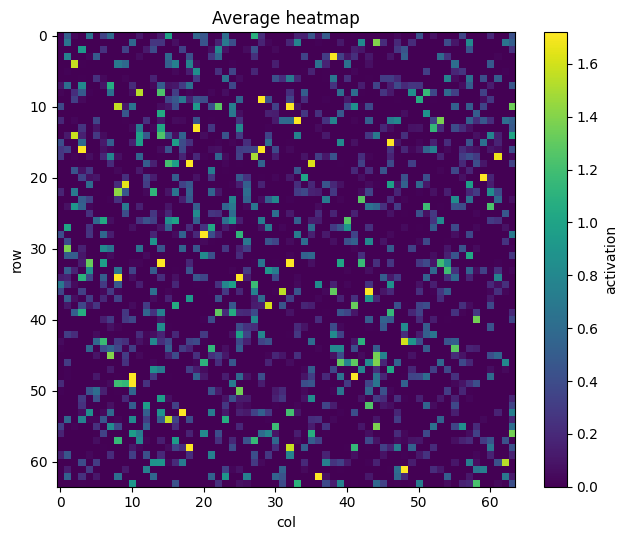

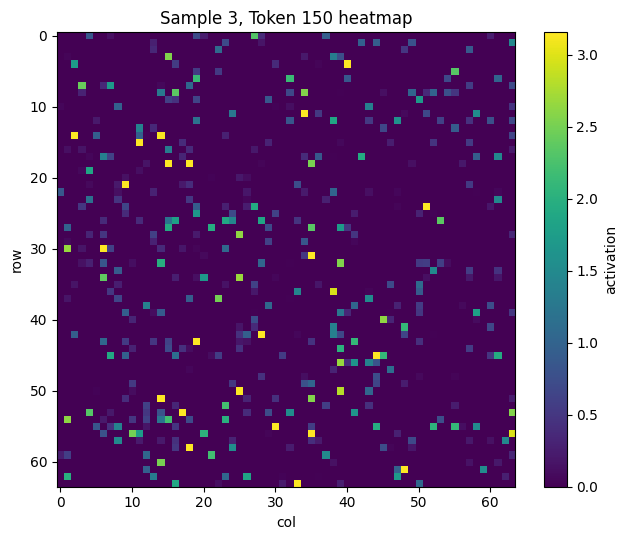

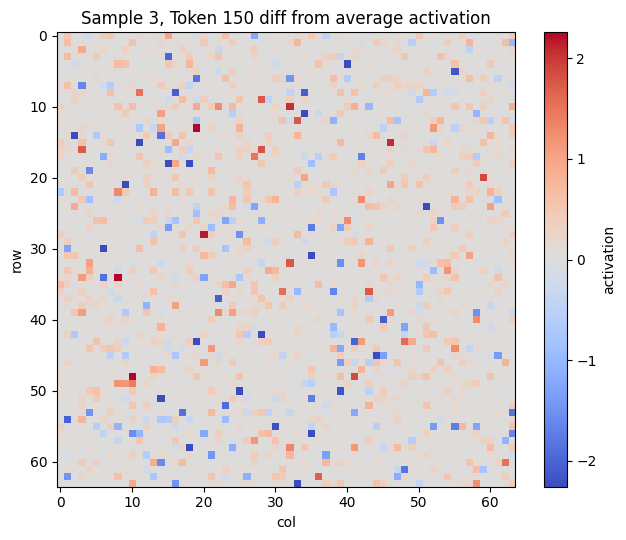

In [92]:
print(f'S_train shape: {S_train.mean(dim=0).shape}')
print(f'Z_train shape: {Z_train[0, 0, :].shape}')
sample = 3
token = 150
sample_enc = sae.encode(Z_train[sample, token, :].float())
heatmap_square(S_train[0], title=f"Average heatmap")
heatmap_square(sample_enc, title=f"Sample {sample}, Token {token} heatmap")
heatmap_square(S_train[0] - sample_enc, title=f"Sample {sample}, Token {token} diff from average activation")